<h1>Neural Network Training Environment</h1>
<p>This notebook is designed to train both the rotation network and recognition network used to extract the seven segment moldcode digits from glass bottles. For a description of the full pipeline and research methodology <a href='https://docs.google.com/document/d/1LVSP-888HSKSlZJJ0qQHxiSSdyhNll-wLGWlapSymoI/edit?usp=sharing'>click here<a><p>
<p><font color='red'><b>After the imports, run only the blocks from the required segments as some blocks may overwrite weight files that have not been saved under different file names. Do not run all cells</b></font></p>

<h2>Imports and Datasets</h2>

In [1]:
import torch
import torch.nn as nn
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.optim as optim
import imutils
from YOLO_Files import train as yolo_train
from YOLO_Files import detect
from YOLO_Files.utils.datasets import *
import rotate_net
import time


device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [2]:
#Define a weights folder here
weights_folder = r'C:\Users\admin\Desktop\Moldcode_Network\weights'

<hr>
<h2>Rotation Networks</h2>
<hr>
<h3>Teacher Rotation Network</h3>
<p>This network is the most involved to train. For reasons beyond my knowledge the augmentation of the data needs to be increased gradually as starting training the full level of augmentation results in models that never converge. I have laid out a table below of the training schedule I used to in order to achieve the results I got.</p>
<table>
    <tr><th>Epoch</th><th>Augmentation</th></tr>
    <tr><td>1-5</td><td>+/-10 degrees</td></tr>
    <tr><td>6-10</td><td>+/-15 degrees</td></tr>
    <tr><td>11-15</td><td>+/-20 degrees</td></tr>
    <tr><td>16-20</td><td>+/-25 degrees</td></tr>
    <tr><td>21-25</td><td>+/-35 degrees</td></tr>
    <tr><td>...</td><td>...</td></tr>
    <tr><td>81-85</td><td>+/-90 degrees</td></tr>
</table>
<p>The level of degree augmentation can be changed in <code>\YOLO_Files\utils\datasets.py</code> line 303. Every 5 epochs took ~12 minutes to train. This time is with 3885 training images.</p>
<p>You will notice in training that there are hard accuracies and soft accuracies. Hard accuracies are outputs that are directly in line with the rotation label. Those labels however are estimated by human eye and always within 5 degree increments. For this reason soft accuracies were added in to give a more realistic sense of how well the network is doing. Soft accuracies give a leniency of 15 degrees to the network. The recognition network these images will be fed into afterwards have been trained with 20 degrees of rotational freedom. Therefore an error of up 15 degrees by the rotation network is completely acceptable.</p>

In [6]:
train_path = r'C:\Users\admin\Desktop\Moldcode_Network\Bottle_Dataset\bottles_train_rotation.txt'
TRot_set_train = LoadImagesAndLabels(train_path, img_size=416, rect=False, rotation_training=True)
TRot_loader_train = DataLoader(TRot_set_train, batch_size=8, num_workers=4, shuffle=True, pin_memory=True, collate_fn=TRot_set_train.collate_fn)

test_path = r'C:\Users\admin\Desktop\Moldcode_Network\Bottle_Dataset\bottles_test_rotation.txt'
TRot_set_test = LoadImagesAndLabels(test_path, img_size=416, rect=False, rotation_training=True, augment=False)
TRot_loader_test = DataLoader(TRot_set_test, batch_size=1, num_workers=4, shuffle=True, pin_memory=True, collate_fn=TRot_set_test.collate_fn)


Reading labels: 100%|████████████████████████████████████████████████████████████| 3885/3885 [00:00<00:00, 5058.15it/s]


In [7]:
TRot_net = rotate_net.Teacher()
#print(TRot_net)
TRot_net = TRot_net.to(device)
optimizer = optim.Adam(TRot_net.parameters())
criterion = nn.CrossEntropyLoss()
epoch_count = 0
best_acc = 0

In [14]:
#This is the block you will need to run, then adjust the augmentation settings as outlined above, before running again.
t = time.time()
for epoch in range(5):
    epoch_count += 1
    running_loss = 0.0
    for i, data in enumerate(TRot_loader_train, 0):
        
        inputs, labels, img_path, _, _ = data
        inputs = inputs.to(device)
        labels = labels.long()
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = TRot_net(inputs)
        loss = criterion(outputs, labels[:, 1])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 199))
            running_loss = 0.0
            
    print("Testing after {} epochs".format(epoch_count))
    #If soft accuracies go above 90% then miscategorized (prediction, label) pairs will print.
    #A prediction of 360 means the network believes there are no digits and therefore no orientation.
    test_acc = rotate_net.test_net(TRot_net, TRot_loader_test, device)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(TRot_net.state_dict(), "{}\TRot_net_{}_{}.pt".format(weights_folder, epoch_count,int(best_acc)))
        print("New best weights saved. {}\TRot_net_{}_{}.pt".format(weights_folder, epoch_count,int(best_acc)))
        
print('Finished Training in {0:2.2f} minutes'.format((time.time()-t)/60))

[1,   100] loss: 1.038
[1,   200] loss: 1.040
[1,   300] loss: 0.997
[1,   400] loss: 0.948
Testing after 16 epochs
Average time per inference: 0.0104
Hard accuracy of predictions on the test images: 57%
Soft accuracy of predictions within 15 degrees of correct label = 0.734
[2,   100] loss: 0.991
[2,   200] loss: 0.879
[2,   300] loss: 0.979
[2,   400] loss: 0.894
Testing after 17 epochs
Average time per inference: 0.0105
Hard accuracy of predictions on the test images: 56%
Soft accuracy of predictions within 15 degrees of correct label = 0.659
[3,   100] loss: 0.857
[3,   200] loss: 0.871
[3,   300] loss: 0.841
[3,   400] loss: 1.213
Testing after 18 epochs
Average time per inference: 0.0107
Hard accuracy of predictions on the test images: 26%
Soft accuracy of predictions within 15 degrees of correct label = 0.486
[4,   100] loss: 1.161
[4,   200] loss: 0.970
[4,   300] loss: 0.838
[4,   400] loss: 0.862
Testing after 19 epochs
Average time per inference: 0.0104
Hard accuracy of pred

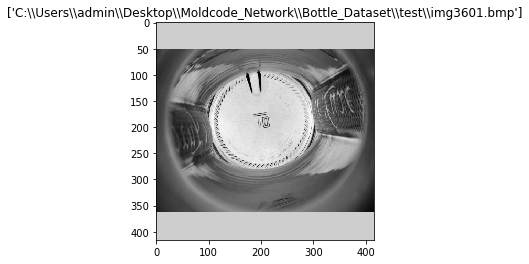

Prediction: 360
Label: 175


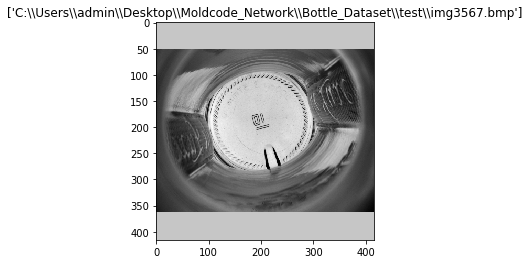

Prediction: 130
Label: 340


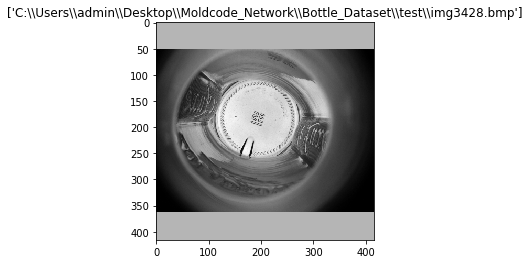

Prediction: 330
Label: 20


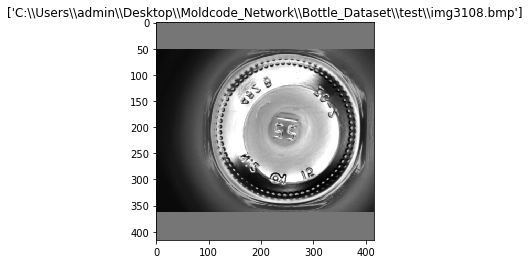

Prediction: 215
Label: 190


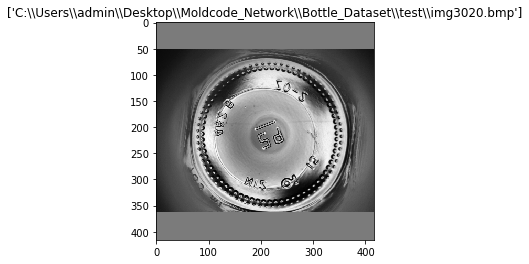

Prediction: 50
Label: 155


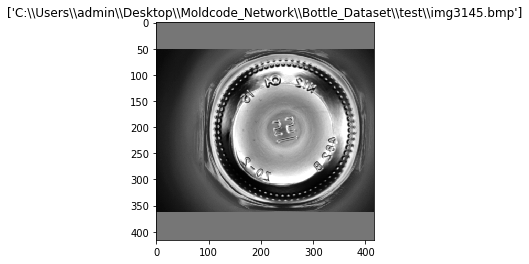

Prediction: 80
Label: 345


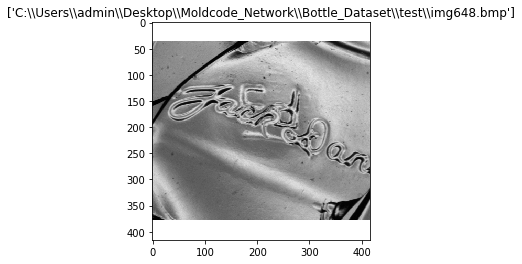

Prediction: 270
Label: 0


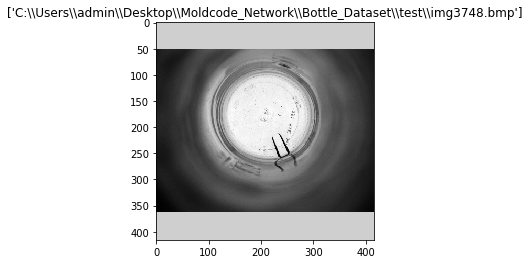

Prediction: 125
Label: 290


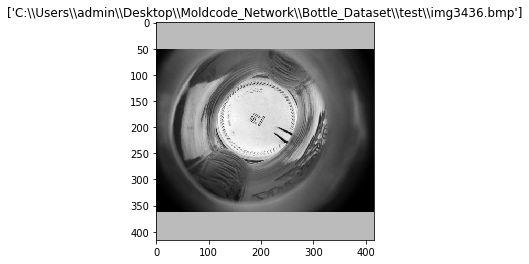

Prediction: 110
Label: 300


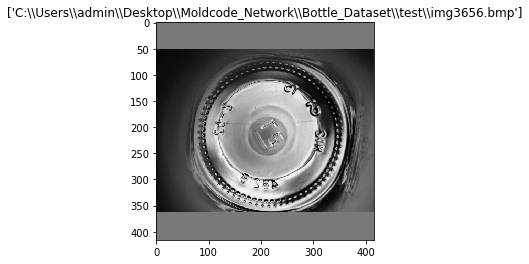

Prediction: 360
Label: 60


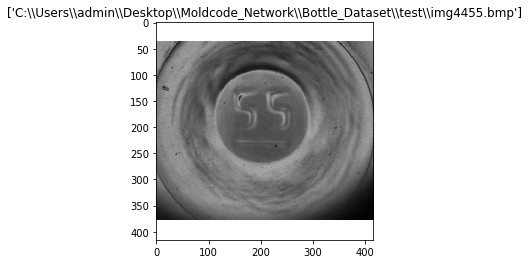

Prediction: 180
Label: 0


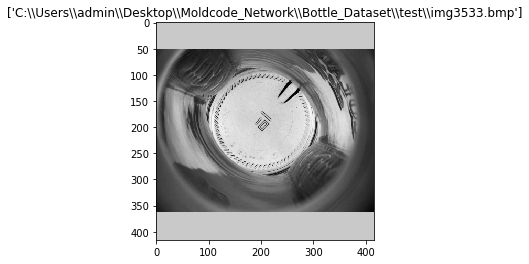

Prediction: 360
Label: 225


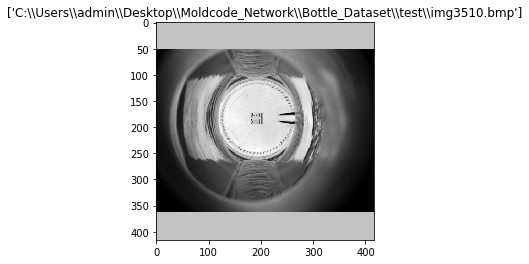

Prediction: 95
Label: 270


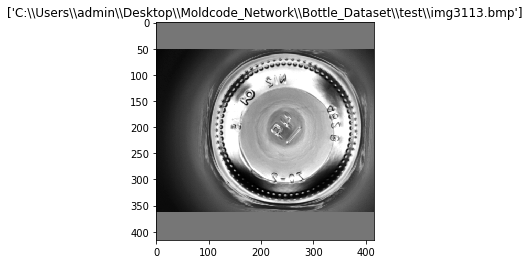

Prediction: 50
Label: 310


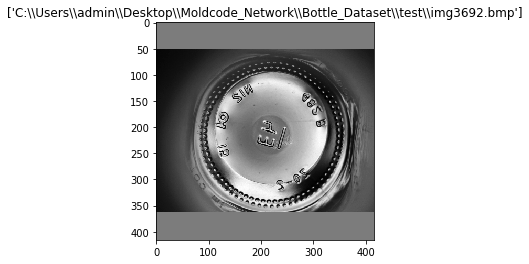

Prediction: 110
Label: 285


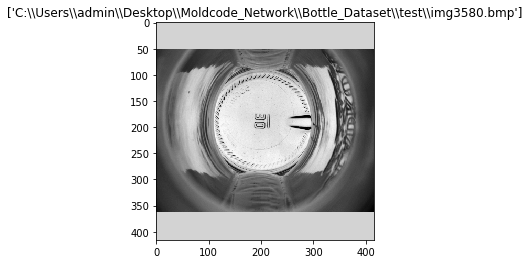

Prediction: 100
Label: 270


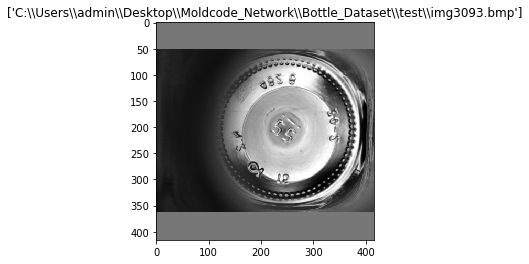

Prediction: 340
Label: 220


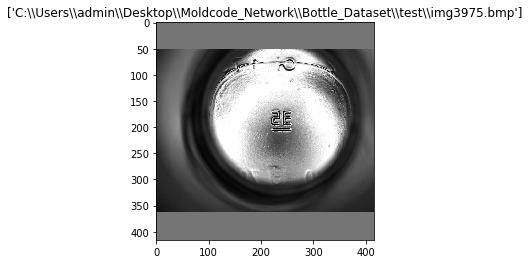

Prediction: 95
Label: 0


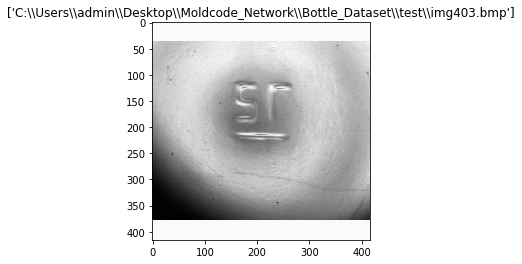

Prediction: 90
Label: 0


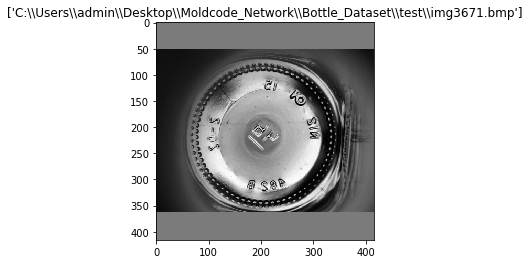

Prediction: 360
Label: 40


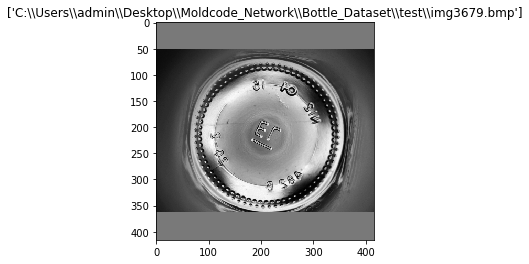

Prediction: 285
Label: 25


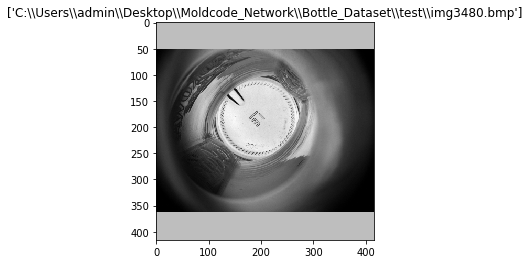

Prediction: 310
Label: 140


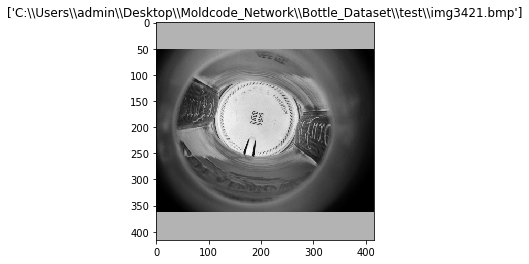

Prediction: 340
Label: 15


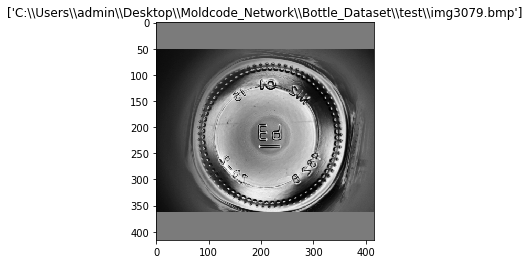

Prediction: 95
Label: 0


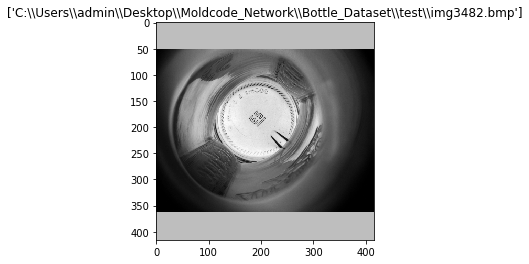

Prediction: 110
Label: 310


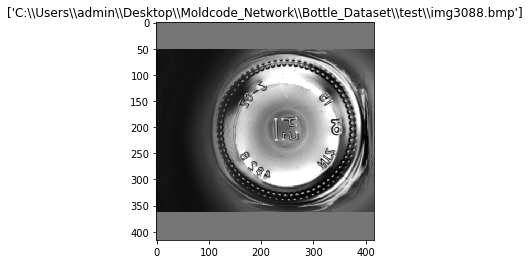

Prediction: 245
Label: 85


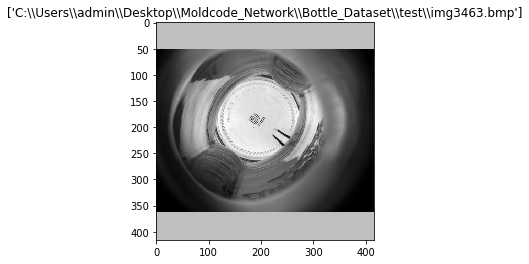

Prediction: 110
Label: 310


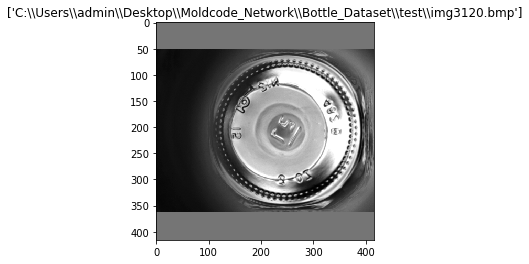

Prediction: 125
Label: 300


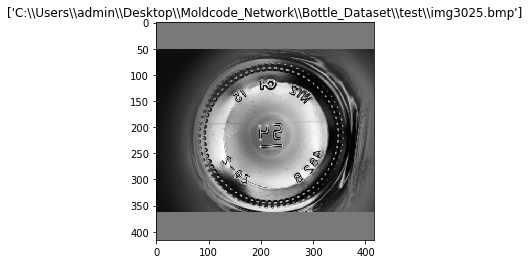

Prediction: 75
Label: 355


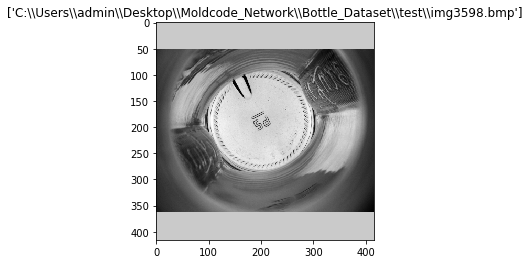

Prediction: 360
Label: 150


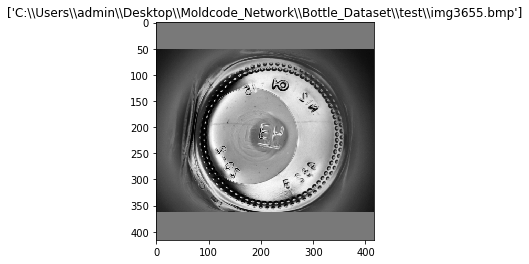

Prediction: 110
Label: 10


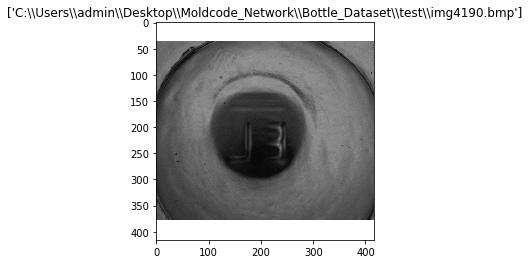

Prediction: 275
Label: 180


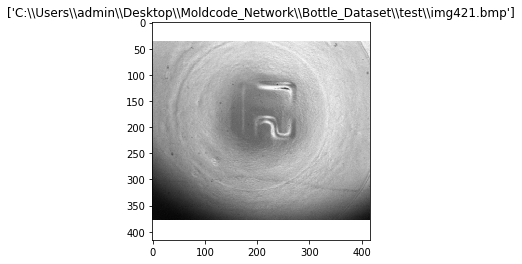

Prediction: 185
Label: 90


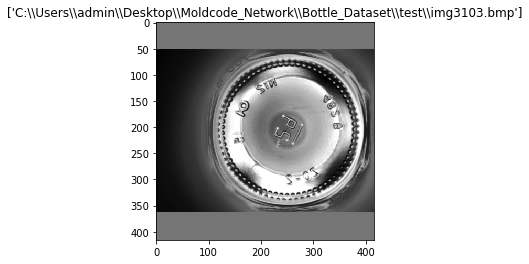

Prediction: 155
Label: 295


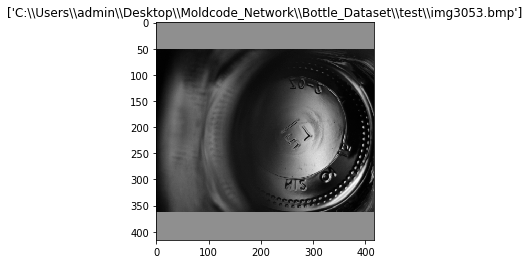

Prediction: 360
Label: 140


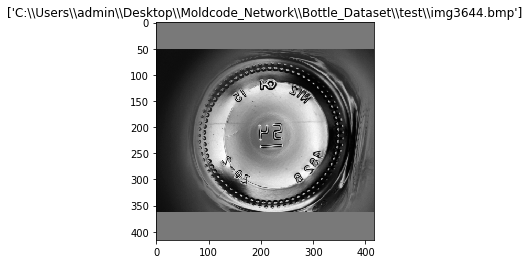

Prediction: 75
Label: 355


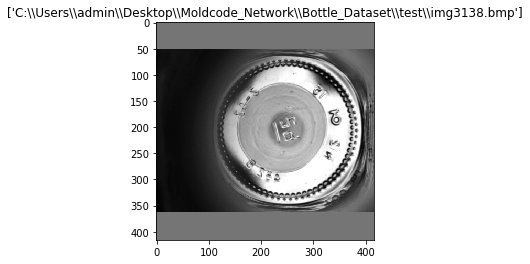

Prediction: 330
Label: 75


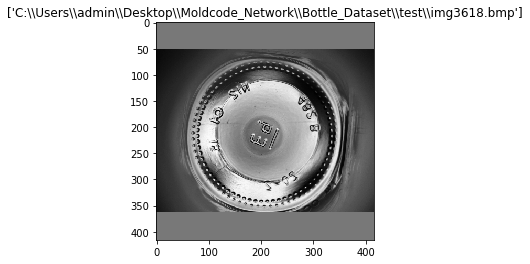

Prediction: 110
Label: 290


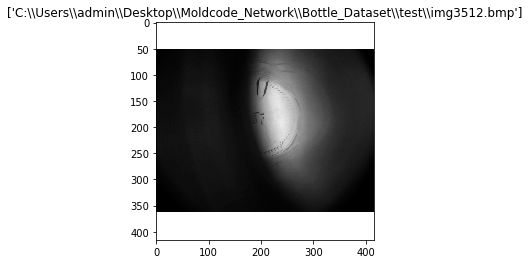

Prediction: 5
Label: 185


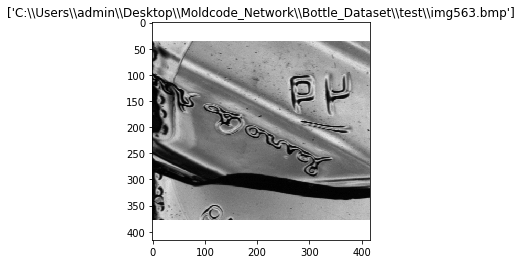

Prediction: 185
Label: 0


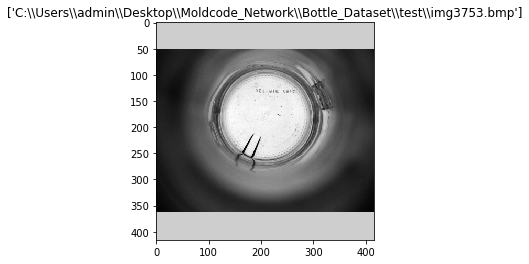

Prediction: 25
Label: 360


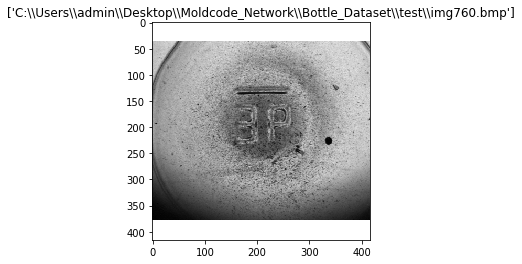

Prediction: 5
Label: 180


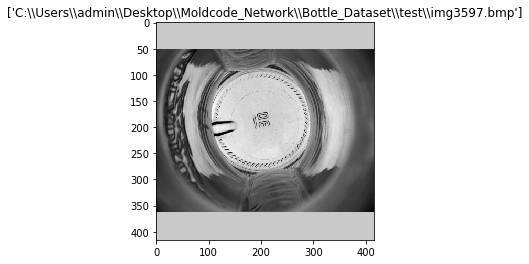

Prediction: 110
Label: 80


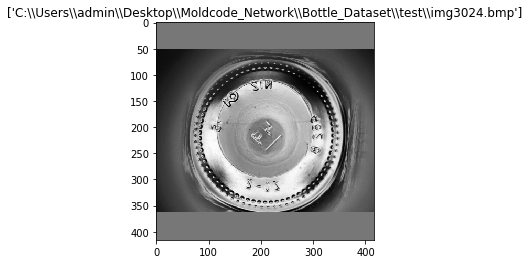

Prediction: 360
Label: 315


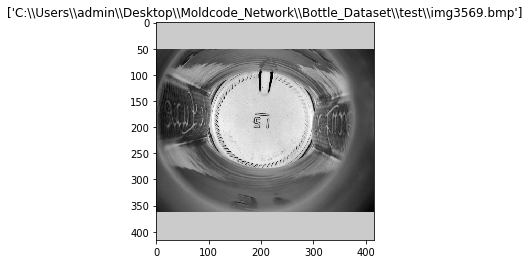

Prediction: 110
Label: 185


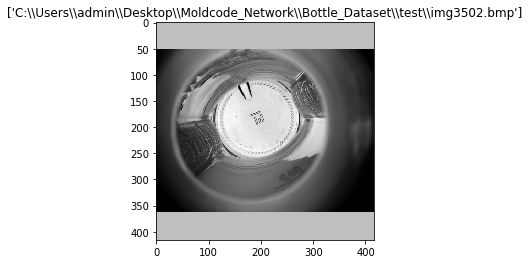

Prediction: 360
Label: 160


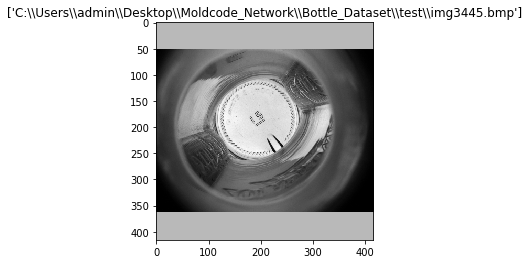

Prediction: 130
Label: 325


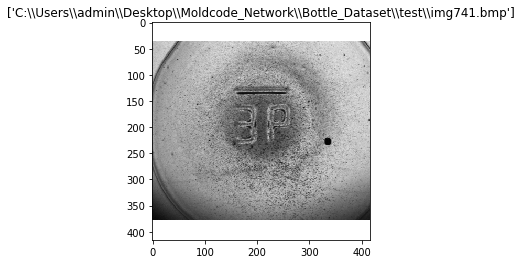

Prediction: 5
Label: 180


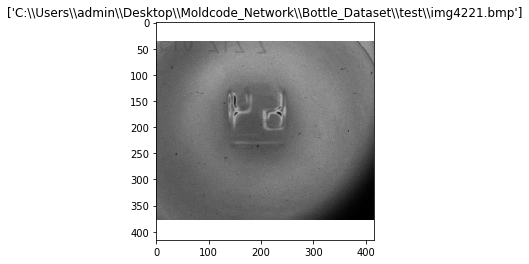

Prediction: 270
Label: 0


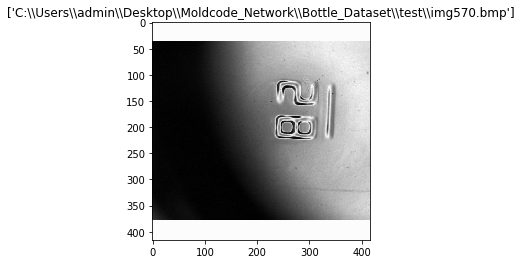

Prediction: 100
Label: 270


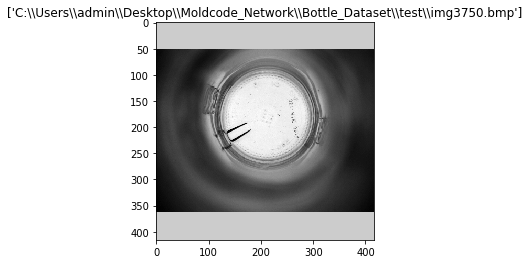

Prediction: 360
Label: 15


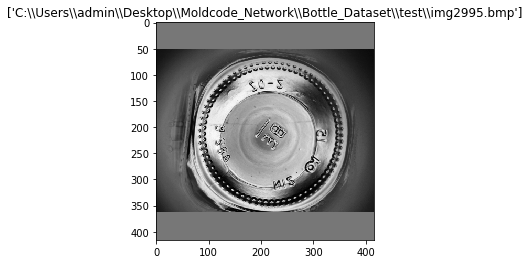

Prediction: 20
Label: 125


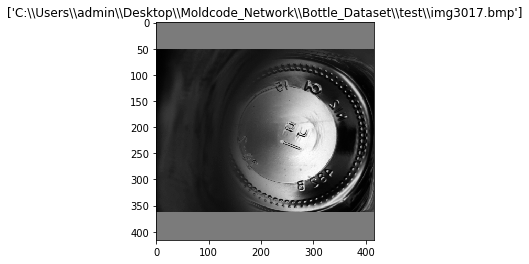

Prediction: 360
Label: 20


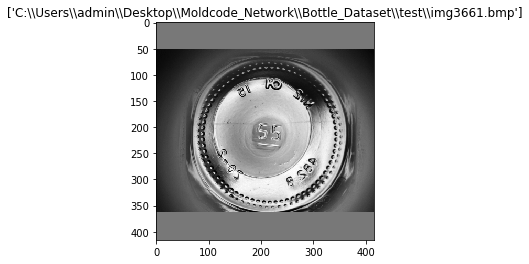

Prediction: 110
Label: 5


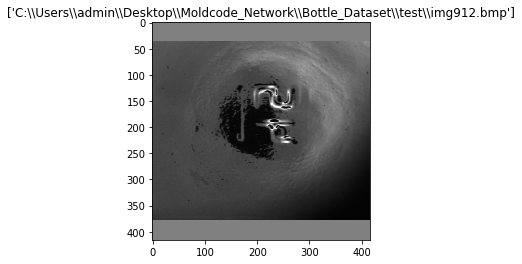

Prediction: 5
Label: 90


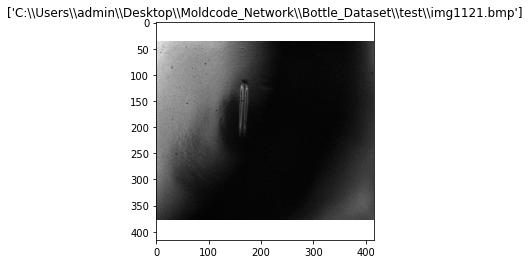

Prediction: 360
Label: 90


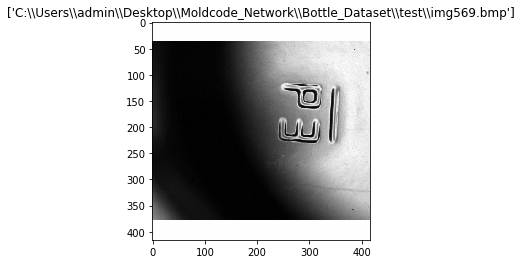

Prediction: 360
Label: 270


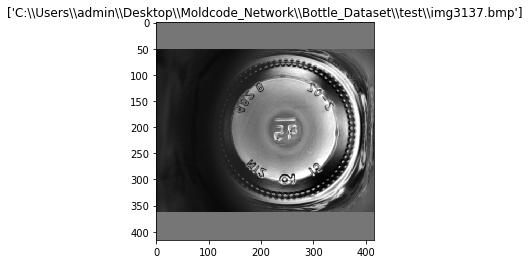

Prediction: 215
Label: 180


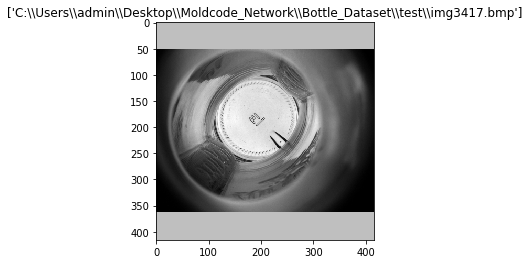

Prediction: 125
Label: 315
Average time per inference: 0.0405
Hard accuracy of predictions on the test images: 78%
Predictions off by more than 15 degrees
[(360, 175), (130, 340), (330, 20), (215, 190), (50, 155), (80, 345), (270, 0), (125, 290), (110, 300), (360, 60), (180, 0), (360, 225), (95, 270), (50, 310), (110, 285), (100, 270), (340, 220), (95, 0), (90, 0), (360, 40), (285, 25), (310, 140), (340, 15), (95, 0), (110, 310), (245, 85), (110, 310), (125, 300), (75, 355), (360, 150), (110, 10), (275, 180), (185, 90), (155, 295), (360, 140), (75, 355), (330, 75), (110, 290), (5, 185), (185, 0), (25, 360), (5, 180), (110, 80), (360, 315), (110, 185), (360, 160), (130, 325), (5, 180), (270, 0), (100, 270), (360, 15), (20, 125), (360, 20), (110, 5), (5, 90), (360, 90), (360, 270), (215, 180), (125, 315)]
Soft accuracy of predictions within 15 degrees of correct label = 0.915


78.03468208092485

In [28]:
#Run this if you'd like to see what the error images are.
rotate_net.test_net(TRot_net, TRot_loader_test, device, show_errors=True)

<h4>Load/Save Weights</h4>
<p>The reason for saving the epoch count as a part of the name is to show the flexibility of the network as it has trained on higher levels of rotational augmentation. High accuracies from low epoch counts should be considered fragile to rotations that don't fit the majority of the data's 0, 90, 180, and 270 rotations.</p>

In [23]:
weight_file = 'TRot_net_20_73.pt'

In [24]:
torch.save(TRot_net.state_dict(), weights_folder + os.sep + weight_file)

In [8]:
TRot_net.load_state_dict(torch.load(weights_folder + os.sep + weight_file))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

<h3>Student Rotation Network</h3>
<p>Student networks will be working with smaller images to help improve speed and need their own loaders as we will be using different loaders to feed the networks. <font color='red'>shuffle must be turned off</font> so that both networks are identifying the same images</p>

In [5]:
train_path = r'C:\Users\admin\Desktop\Moldcode_Network\Bottle_Dataset\bottles_train_rotation.txt'
#Student network will be working with smaller images to help improve speed and needs it's own loader
#As we will be using different loaders to feed the networks we need to make sure that shuffle is turned off
#so that both networks are identifying the same images
SRot_set_train = LoadImagesAndLabels(train_path, img_size=256, rect=False, rotation_training=True, student=True)
SRot_loader_train = DataLoader(SRot_set_train, batch_size=8, num_workers=4, shuffle=False, pin_memory=True, collate_fn=SRot_set_train.collate_fn)

TRot_set_train = LoadImagesAndLabels(train_path, img_size=416, rect=False, rotation_training=True)
TRot_loader_train = DataLoader(TRot_set_train, batch_size=1, num_workers=4, shuffle=False, pin_memory=True, collate_fn=TRot_set_train.collate_fn)

test_path = r'C:\Users\admin\Desktop\Moldcode_Network\Bottle_Dataset\bottles_test_rotation.txt'
SRot_set_test = LoadImagesAndLabels(test_path, img_size=256, rect=False, rotation_training=True, augment=False)
SRot_loader_test = DataLoader(SRot_set_test, batch_size=1, num_workers=4, shuffle=True, pin_memory=True, collate_fn=SRot_set_test.collate_fn)


Reading labels: 100%|████████████████████████████████████████████████████████████| 3885/3885 [00:00<00:00, 7694.53it/s]


<p>This next cell will take the geometric mean of the outputs of every set of teacher weights and save those as the targets for the student network. <font color='red'>Please make sure the weights folder only includes quality sets of weights.</font> The student network will be trained with these averaged outputs.</p>

In [ ]:
teacher_nets = []

with os.scandir(weights_folder) as folder:
    for file in folder:
        if "TRot" in file.name:
            teacher = rotate_net.Teacher()
            teacher.load_state_dict(torch.load(weights_folder + os.sep + file.name))
            teacher.eval()
            teacher_nets.append(teacher)
with torch.no_grad():            
    for i, data in enumerate(TRot_loader_train, 0):
        inputs, labels, img_path, _, teacher_outputs = data
        inputs = inputs.to(device)
        labels = labels.long()
        labels = labels.to(device)

        outputs = torch.zeros((1,73)).to(device)
        for net in teacher_nets:
            net.to(device)
            outputs = outputs + net(inputs)
            net.to('cpu')
        outputs =  outputs / len(teacher_nets)
        outputs = outputs.cpu().numpy()
        print(img_path[0][:-4] + ".teacher")
        np.save(img_path[0][:-4] + ".teacher", outputs)

In [ ]:
def kd_loss(outputs, labels, teacher_outputs, alhpa, temperature):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """
    a = alpha
    T = temperature
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (a * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - a)

    return KD_loss

In [ ]:
SRot_net = rotate_net.Student()
#print(TRot_net)
SRot_net = SRot_net.to(device)
optimizer = optim.Adam(SRot_net.parameters())
criterion = kd_loss()
epoch_count = 0
best_acc = 0
alpha = 0.3
temp = 20

In [ ]:
t = time.time()
for epoch in range(50):
    epoch_count += 1
    running_loss = 0.0
    for i, data in enumerate(SRot_loader_train, 0):
        
        inputs, labels, img_path, _, teacher_outputs = data
        inputs = inputs.to(device)
        labels = labels.long()
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = TRot_net(inputs)
        loss = criterion(outputs, labels[:, 1], teacher_outputs, alpha, temp)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 199))
            running_loss = 0.0
            
    print("Testing after {} epochs".format(epoch_count))
    #If soft accuracies go above 90% then miscategorized (prediction, label) pairs will print.
    #A prediction of 360 means the network believes there are no digits and therefore no orientation.
    test_acc = rotate_net.test_net(TRot_net, TRot_loader_test, device)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(TRot_net.state_dict(), "{}\TRot_net_{}_{}.pt".format(weights_folder, epoch_count,int(best_acc)))
        print("New best weights saved. {}\TRot_net_{}_{}.pt".format(weights_folder, epoch_count,int(best_acc)))
        
print('Finished Training in {0:2.2f} minutes'.format((time.time()-t)/60))

<hr>
<h2>Teacher Recognition Networks</h2>
<hr>

<h3>Teacher Recognition Network</h3>
<p>For this network I recommend training for 100 epochs. Though some great results came out around 60 I found I was able to squeeze an extra percentage of accuracy around 90 epochs. Depending on your GPU this will take some time. Basically a day. No funny business with the augmentation for this network. Just let it run, this means you can definitely just get your computer to train these networks overnight after mild supervision at the beginning to make sure it's training properly.<p>

In [3]:
yolo_train.train(
        r'C:\Users\admin\Desktop\Moldcode_Network\YOLO_Files\bottles_yolov3.cfg',
        r'C:\Users\admin\Desktop\Moldcode_Network\YOLO_Files\bottles.data',
        img_size=416,
        resume=False,
        transfer=False,
        epochs=200,
        batch_size=8,
        accumulate=4,
        multi_scale=False,
        notest=False
    )

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080', total_memory=8192MB)

C:\Users\admin\Desktop\Moldcode_Network\YOLO_Files\bottles_train.txt


Reading labels: 100%|████████████████████████████████████████████████████████████| 3885/3885 [00:00<00:00, 5366.35it/s]


Model Summary: 222 layers, 6.15716e+07 parameters, 6.15716e+07 gradients

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   0/199     199/485     0.249     0.104      22.6       1.3      24.3        16      84.1
   0/199     399/485     0.251    0.0919      11.5      1.28      13.1        16      73.1
               Class    Images   Targets         P         R       mAP        F1


Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  2.29it/s]


                 all       692  1.36e+03         0         0         0         0
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292         0         0         0         0
                   3       692       224         0         0         0         0
                   4       692       205         0         0         0         0
                   5       692       157         0         0         0         0
                   6       692       137         0         0         0         0
                   7       692       148         0         0         0         0
                   8       692        82         0         0         0         0
                   9       692        93         0         0         0         0

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   1/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:23<00:00,  3.72it/s]


                 all       692  1.36e+03    0.0616    0.0179   0.00329    0.0257
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.174    0.0651    0.0127    0.0948
                   3       692       224    0.0289    0.0223  0.000907    0.0252
                   4       692       205         0         0         0         0
                   5       692       157     0.169    0.0701    0.0153    0.0991
                   6       692       137    0.0769    0.0146   0.00292    0.0245
                   7       692       148     0.167   0.00676   0.00113     0.013
                   8       692        82         0         0         0         0
                   9       692        93         0         0         0         0

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   2/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:25<00:00,  3.43it/s]


                 all       692  1.36e+03    0.0213   0.00867   0.00315    0.0113
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292    0.0132    0.0137   0.00261    0.0134
                   3       692       224    0.0199    0.0179   0.00359    0.0188
                   4       692       205    0.0984    0.0293    0.0168    0.0451
                   5       692       157    0.0769    0.0191   0.00838    0.0306
                   6       692       137         0         0         0         0
                   7       692       148   0.00435   0.00676  9.65e-05   0.00529
                   8       692        82         0         0         0         0
                   9       692        93         0         0         0         0

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   3/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:25<00:00,  3.45it/s]


                 all       692  1.36e+03     0.164    0.0704    0.0201     0.084
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.236     0.188     0.051      0.21
                   3       692       224     0.181      0.17    0.0371     0.175
                   4       692       205     0.247    0.0976    0.0268      0.14
                   5       692       157         0         0         0         0
                   6       692       137     0.268    0.0803    0.0221     0.124
                   7       692       148    0.0783     0.115   0.00993    0.0932
                   8       692        82         0         0         0         0
                   9       692        93     0.625    0.0538    0.0538     0.099

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   4/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:25<00:00,  3.46it/s]


                 all       692  1.36e+03     0.183    0.0883    0.0483     0.108
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292      0.24     0.137    0.0647     0.174
                   3       692       224     0.157      0.25    0.0715     0.193
                   4       692       205     0.124    0.0634   0.00785    0.0839
                   5       692       157      0.35    0.0446    0.0317    0.0791
                   6       692       137         0         0         0         0
                   7       692       148     0.193     0.108    0.0351     0.139
                   8       692        82         0         0         0         0
                   9       692        93     0.765      0.28     0.272     0.409

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   5/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:25<00:00,  3.40it/s]


                 all       692  1.36e+03      0.24     0.138    0.0809     0.165
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.406     0.147    0.0838     0.216
                   3       692       224     0.192     0.263    0.0679     0.222
                   4       692       205     0.204     0.137     0.031     0.164
                   5       692       157         0         0         0         0
                   6       692       137     0.469     0.109    0.0681     0.178
                   7       692       148     0.333     0.257     0.114      0.29
                   8       692        82     0.111    0.0244   0.00488      0.04
                   9       692        93     0.683     0.441     0.439     0.536

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   6/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:25<00:00,  3.36it/s]


                 all       692  1.36e+03     0.425     0.249     0.163      0.31
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.502     0.353     0.246     0.414
                   3       692       224     0.321     0.281    0.0975       0.3
                   4       692       205      0.49     0.234     0.121     0.317
                   5       692       157       0.5     0.229     0.151     0.314
                   6       692       137     0.667     0.394     0.287     0.495
                   7       692       148     0.496     0.412     0.234      0.45
                   8       692        82     0.325     0.159    0.0665     0.213
                   9       692        93     0.952      0.43     0.424     0.593

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   7/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:26<00:00,  3.30it/s]


                 all       692  1.36e+03     0.501     0.324     0.243     0.384
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.634     0.421      0.33     0.506
                   3       692       224     0.365     0.272     0.109     0.312
                   4       692       205     0.736     0.312     0.262     0.438
                   5       692       157     0.689     0.268     0.213     0.385
                   6       692       137     0.541     0.336     0.189     0.414
                   7       692       148     0.631     0.682     0.526     0.656
                   8       692        82     0.444     0.341     0.203     0.386
                   9       692        93     0.966     0.602     0.599     0.742

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   8/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:26<00:00,  3.24it/s]


                 all       692  1.36e+03     0.535     0.334     0.264     0.395
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.741     0.442     0.401     0.554
                   3       692       224     0.507     0.317     0.183      0.39
                   4       692       205     0.784     0.337     0.284     0.471
                   5       692       157     0.605     0.312     0.211     0.412
                   6       692       137     0.602     0.496     0.366     0.544
                   7       692       148     0.461     0.676     0.491     0.548
                   8       692        82     0.733     0.268      0.22     0.393
                   9       692        93      0.92     0.495     0.485     0.643

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
   9/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:26<00:00,  3.25it/s]


                 all       692  1.36e+03     0.663     0.421      0.39     0.508
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.845     0.503      0.46     0.631
                   3       692       224     0.777     0.357     0.313     0.489
                   4       692       205     0.859     0.415     0.393     0.559
                   5       692       157     0.905     0.427     0.412      0.58
                   6       692       137     0.848     0.569     0.531     0.681
                   7       692       148     0.782      0.75     0.689     0.766
                   8       692        82     0.662     0.524     0.435     0.585
                   9       692        93     0.954     0.667     0.663     0.785

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  10/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  5.84it/s]


                 all       692  1.36e+03     0.557      0.39     0.326     0.451
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.658     0.671      0.62     0.664
                   3       692       224     0.581     0.464     0.386     0.516
                   4       692       205     0.731     0.278     0.205     0.403
                   5       692       157     0.573     0.376     0.235     0.454
                   6       692       137     0.667     0.467     0.331     0.549
                   7       692       148     0.823     0.439     0.408     0.573
                   8       692        82     0.662     0.524     0.402     0.585
                   9       692        93     0.875     0.677     0.671     0.764

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  11/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  3.13it/s]


                 all       692  1.36e+03     0.618     0.447     0.408     0.516
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.798     0.623     0.586       0.7
                   3       692       224     0.674     0.406     0.348     0.507
                   4       692       205     0.833     0.561     0.539     0.671
                   5       692       157      0.68      0.42     0.312      0.52
                   6       692       137     0.759     0.642     0.565     0.696
                   7       692       148     0.697     0.622     0.558     0.657
                   8       692        82      0.83     0.476     0.459     0.605
                   9       692        93     0.905      0.72     0.716     0.802

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  12/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  5.88it/s]


                 all       692  1.36e+03     0.538     0.429      0.36     0.474
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.728     0.613     0.554     0.665
                   3       692       224     0.676     0.513     0.448     0.584
                   4       692       205     0.831     0.551     0.506     0.663
                   5       692       157     0.678     0.752     0.727     0.713
                   6       692       137     0.807     0.701      0.65      0.75
                   7       692       148     0.429     0.304      0.14     0.356
                   8       692        82     0.596     0.378     0.257     0.463
                   9       692        93     0.638     0.473     0.315     0.543

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  13/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  3.19it/s]


                 all       692  1.36e+03     0.728      0.53     0.521     0.613
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.941     0.654      0.65     0.772
                   3       692       224      0.81     0.496     0.475     0.615
                   4       692       205     0.888     0.698     0.682     0.781
                   5       692       157     0.966      0.72     0.719     0.825
                   6       692       137     0.924     0.708     0.695     0.802
                   7       692       148     0.951     0.655     0.648     0.776
                   8       692        82     0.891     0.695     0.667     0.781
                   9       692        93     0.913     0.677     0.674     0.778

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  14/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.09it/s]


                 all       692  1.36e+03     0.729     0.593     0.585     0.653
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.915     0.733     0.728     0.814
                   3       692       224      0.77     0.567     0.524     0.653
                   4       692       205      0.96     0.698     0.695     0.808
                   5       692       157      0.88     0.796     0.787     0.836
                   6       692       137     0.926      0.73     0.729     0.816
                   7       692       148     0.984     0.818     0.818     0.893
                   8       692        82      0.88     0.805     0.796     0.841
                   9       692        93     0.973     0.785     0.776     0.869

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  15/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  3.16it/s]


                 all       692  1.36e+03       0.7     0.597     0.585     0.643
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.842     0.712       0.7     0.772
                   3       692       224     0.698     0.567     0.538     0.626
                   4       692       205     0.955     0.717     0.703     0.819
                   5       692       157      0.78      0.79     0.746     0.785
                   6       692       137     0.917     0.723     0.719     0.808
                   7       692       148     0.954     0.838     0.835     0.892
                   8       692        82     0.901      0.78     0.773     0.837
                   9       692        93     0.951     0.839     0.835     0.891

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  16/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.07it/s]


                 all       692  1.36e+03     0.734      0.59     0.579     0.653
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.929     0.675     0.671     0.782
                   3       692       224     0.734     0.603     0.568     0.662
                   4       692       205     0.986     0.712     0.712     0.827
                   5       692       157      0.91     0.771     0.759     0.834
                   6       692       137     0.952     0.723     0.715     0.822
                   7       692       148     0.956     0.878     0.869     0.915
                   8       692        82     0.906     0.707     0.674     0.795
                   9       692        93     0.963     0.828     0.825      0.89

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  17/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  3.16it/s]


                 all       692  1.36e+03     0.743     0.598     0.594      0.66
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.974     0.637     0.636      0.77
                   3       692       224     0.881     0.562      0.56     0.687
                   4       692       205     0.967     0.722     0.721     0.827
                   5       692       157     0.947     0.796     0.794     0.865
                   6       692       137     0.957      0.81     0.809     0.877
                   7       692       148     0.884     0.872     0.859     0.878
                   8       692        82     0.871     0.744     0.726     0.803
                   9       692        93     0.951     0.839     0.839     0.891

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  18/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.09it/s]


                 all       692  1.36e+03     0.738     0.592     0.585     0.655
                   0       692         7         0         0         0         0
                   1       692        10         0         0         0         0
                   2       692       292     0.819     0.695     0.662     0.752
                   3       692       224     0.764     0.536     0.515      0.63
                   4       692       205     0.981     0.737     0.736     0.841
                   5       692       157     0.971     0.866     0.865     0.916
                   6       692       137      0.99     0.715     0.715     0.831
                   7       692       148     0.942     0.885     0.882     0.913
                   8       692        82     0.923     0.732     0.724     0.816
                   9       692        93     0.986     0.753     0.752     0.854

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  19/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:27<00:00,  3.11it/s]


                 all       692  1.36e+03     0.719      0.57     0.534     0.635
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.808     0.736     0.703     0.771
                   3       692       224     0.906     0.558     0.536     0.691
                   4       692       205     0.969     0.766     0.764     0.856
                   5       692       157     0.873     0.745     0.652     0.804
                   6       692       137     0.962     0.745     0.731      0.84
                   7       692       148     0.958     0.764     0.735      0.85
                   8       692        82     0.857     0.659      0.58     0.745
                   9       692        93     0.861     0.731     0.638     0.791

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  20/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.03it/s]


                 all       692  1.36e+03     0.708     0.599     0.585     0.648
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.803     0.685     0.613     0.739
                   3       692       224     0.684     0.571      0.54     0.623
                   4       692       205     0.938     0.737     0.736     0.825
                   5       692       157     0.964     0.841      0.84     0.898
                   6       692       137     0.944     0.745     0.741     0.833
                   7       692       148     0.984     0.858     0.849     0.917
                   8       692        82      0.81      0.78     0.757     0.795
                   9       692        93     0.947     0.774     0.774     0.852

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  21/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.05it/s]


                 all       692  1.36e+03     0.729     0.627     0.618     0.673
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.831      0.74     0.729     0.783
                   3       692       224     0.854     0.652     0.645     0.739
                   4       692       205     0.952     0.776      0.77     0.855
                   5       692       157     0.925     0.866     0.856     0.895
                   6       692       137     0.956     0.788     0.783     0.864
                   7       692       148      0.95     0.892     0.883      0.92
                   8       692        82     0.865      0.78     0.741     0.821
                   9       692        93      0.96     0.774     0.771     0.857

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  22/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.09it/s]


                 all       692  1.36e+03     0.736     0.633     0.627     0.678
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.812     0.767     0.744     0.789
                   3       692       224     0.926     0.612     0.609     0.737
                   4       692       205     0.943      0.81     0.808     0.871
                   5       692       157     0.993     0.904     0.904     0.947
                   6       692       137     0.981     0.759     0.759     0.856
                   7       692       148     0.951     0.919      0.91     0.935
                   8       692        82     0.756      0.72     0.692     0.738
                   9       692        93         1     0.839     0.839     0.912

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  23/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.82it/s]


                 all       692  1.36e+03     0.708     0.639     0.621     0.671
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.808     0.764     0.676     0.785
                   3       692       224     0.777     0.607     0.581     0.682
                   4       692       205     0.888      0.81     0.805     0.847
                   5       692       157     0.916     0.898     0.888     0.907
                   6       692       137     0.947     0.788     0.786     0.861
                   7       692       148     0.965     0.926     0.915     0.945
                   8       692        82      0.79      0.78     0.752     0.785
                   9       692        93     0.987     0.817     0.812     0.894

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  24/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.79it/s]


                 all       692  1.36e+03     0.745     0.664     0.661     0.701
                   0       692         7         0         0         0         0
                   1       692        10         0         0         0         0
                   2       692       292     0.912     0.818     0.814     0.863
                   3       692       224     0.849     0.679     0.672     0.754
                   4       692       205     0.966     0.824     0.824     0.889
                   5       692       157     0.973     0.904     0.903     0.937
                   6       692       137     0.965     0.803       0.8     0.876
                   7       692       148     0.986     0.919     0.919     0.951
                   8       692        82     0.812     0.841     0.827     0.826
                   9       692        93     0.988     0.849     0.849     0.913

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  25/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.00it/s]


                 all       692  1.36e+03     0.692     0.632     0.603      0.66
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.792     0.781     0.678     0.786
                   3       692       224     0.614     0.612     0.536     0.613
                   4       692       205     0.943       0.8     0.794     0.865
                   5       692       157     0.874     0.841     0.797     0.857
                   6       692       137     0.991     0.832     0.829     0.905
                   7       692       148     0.985     0.892     0.886     0.936
                   8       692        82     0.795     0.756     0.732     0.775
                   9       692        93     0.926     0.806     0.778     0.862

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  26/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.73it/s]


                 all       692  1.36e+03     0.712      0.64     0.604     0.673
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.897     0.801     0.735     0.846
                   3       692       224     0.641     0.621     0.413      0.63
                   4       692       205     0.977     0.815     0.814     0.888
                   5       692       157     0.966     0.911     0.906     0.938
                   6       692       137     0.991      0.81      0.81     0.892
                   7       692       148         1     0.892     0.892     0.943
                   8       692        82     0.714     0.732     0.671     0.723
                   9       692        93     0.938     0.817     0.796     0.874

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  27/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.64it/s]


                 all       692  1.36e+03     0.679     0.643     0.601     0.658
                   0       692         7         0         0         0         0
                   1       692        11         0         0         0         0
                   2       692       292     0.795     0.757     0.705     0.775
                   3       692       224     0.813     0.777      0.69     0.795
                   4       692       205     0.944     0.829     0.818     0.883
                   5       692       157     0.772     0.713     0.599     0.742
                   6       692       137     0.931     0.788     0.763     0.854
                   7       692       148     0.972     0.946     0.939     0.959
                   8       692        82     0.602     0.793     0.671     0.684
                   9       692        93     0.963     0.828     0.824      0.89

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  28/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.73it/s]


                 all       692  1.36e+03     0.706     0.629     0.593     0.664
                   0       692         7         0         0         0         0
                   1       692        11         0         0         0         0
                   2       692       292     0.765     0.726      0.57     0.745
                   3       692       224     0.823     0.808      0.78     0.815
                   4       692       205     0.959     0.795     0.787     0.869
                   5       692       157     0.973     0.904     0.903     0.937
                   6       692       137     0.983     0.825     0.821     0.897
                   7       692       148     0.906     0.784     0.713     0.841
                   8       692        82     0.728      0.72     0.645     0.724
                   9       692        93     0.919     0.731     0.713     0.814

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  29/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.06it/s]


                 all       692  1.36e+03      0.75     0.664     0.658     0.702
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292      0.83     0.818     0.786     0.824
                   3       692       224     0.967     0.647     0.644     0.775
                   4       692       205     0.966     0.834     0.831     0.895
                   5       692       157     0.953     0.904     0.903     0.928
                   6       692       137     0.967     0.861      0.86     0.911
                   7       692       148     0.964     0.905     0.898     0.934
                   8       692        82     0.855     0.866     0.848     0.861
                   9       692        93         1     0.806     0.806     0.893

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  30/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.84it/s]


                 all       692  1.36e+03     0.718     0.647     0.632      0.68
                   0       692         7         0         0         0         0
                   1       692        11         0         0         0         0
                   2       692       292     0.862     0.771     0.732     0.814
                   3       692       224     0.698     0.723     0.644     0.711
                   4       692       205     0.937     0.795     0.789      0.86
                   5       692       157     0.986     0.898     0.897      0.94
                   6       692       137     0.974     0.818     0.816     0.889
                   7       692       148     0.977     0.872     0.866     0.921
                   8       692        82     0.768     0.768     0.742     0.768
                   9       692        93     0.975     0.828     0.828     0.895

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  31/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.04it/s]


                 all       692  1.36e+03     0.727     0.658     0.631     0.689
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.792     0.705     0.583     0.746
                   3       692       224     0.869     0.768     0.729     0.815
                   4       692       205     0.972     0.834     0.833     0.898
                   5       692       157     0.965     0.866     0.857     0.913
                   6       692       137     0.959     0.861     0.858     0.908
                   7       692       148      0.93     0.811     0.755     0.866
                   8       692        82     0.804     0.902     0.885     0.851
                   9       692        93     0.975     0.828     0.809     0.895

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  32/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.711     0.654      0.63     0.681
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.875     0.767     0.741     0.818
                   3       692       224     0.615     0.643     0.499     0.629
                   4       692       205     0.972     0.839     0.838     0.901
                   5       692       157      0.94     0.904     0.898     0.922
                   6       692       137     0.992     0.869     0.869     0.926
                   7       692       148         1     0.899     0.899     0.947
                   8       692        82     0.795     0.805     0.762       0.8
                   9       692        93     0.916     0.817     0.796     0.864

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  33/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.04it/s]


                 all       692  1.36e+03     0.746     0.663     0.649     0.702
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.947     0.853     0.847     0.897
                   3       692       224     0.773     0.701     0.598     0.735
                   4       692       205     0.964     0.776     0.767     0.859
                   5       692       157     0.979     0.892     0.888     0.933
                   6       692       137      0.95     0.839     0.839     0.891
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82     0.857     0.805      0.79      0.83
                   9       692        93     0.988      0.86      0.86      0.92

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  34/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.91it/s]


                 all       692  1.36e+03     0.704     0.622     0.589      0.66
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.864     0.764      0.73     0.811
                   3       692       224     0.583     0.625     0.431     0.603
                   4       692       205     0.988     0.785     0.782     0.875
                   5       692       157     0.949     0.828     0.815     0.884
                   6       692       137     0.992     0.854     0.854     0.918
                   7       692       148     0.896     0.811     0.757     0.851
                   8       692        82     0.847     0.744     0.724     0.792
                   9       692        93     0.926     0.806     0.802     0.862

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  35/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.84it/s]


                 all       692  1.36e+03     0.747     0.657      0.65     0.698
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.904     0.777     0.771     0.836
                   3       692       224     0.908      0.75      0.72     0.822
                   4       692       205     0.962     0.854     0.848     0.904
                   5       692       157     0.979     0.885     0.882      0.93
                   6       692       137     0.982      0.81      0.81     0.888
                   7       692       148     0.993     0.919     0.919     0.954
                   8       692        82     0.753     0.744     0.726     0.748
                   9       692        93     0.987     0.828     0.827     0.901

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  36/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.85it/s]


                 all       692  1.36e+03     0.819     0.719     0.711     0.759
                   0       692         7     0.667     0.286     0.286       0.4
                   1       692        13         0         0         0         0
                   2       692       292      0.96     0.894     0.887     0.926
                   3       692       224     0.921     0.777     0.756     0.843
                   4       692       205     0.966     0.839     0.836     0.898
                   5       692       157     0.947     0.917     0.914     0.932
                   6       692       137     0.944     0.869     0.859     0.905
                   7       692       148     0.985     0.892     0.891     0.936
                   8       692        82     0.851     0.902     0.871     0.876
                   9       692        93      0.95     0.817      0.81     0.879

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  37/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.01it/s]


                 all       692  1.36e+03     0.742     0.682     0.668      0.71
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.952     0.877     0.875     0.913
                   3       692       224     0.977     0.759     0.757     0.854
                   4       692       205     0.957     0.878     0.872     0.916
                   5       692       157     0.932     0.873     0.866     0.901
                   6       692       137      0.96     0.876     0.871     0.916
                   7       692       148     0.993     0.939     0.938     0.965
                   8       692        82     0.711      0.78     0.669     0.744
                   9       692        93      0.94     0.839     0.832     0.886

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  38/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.01it/s]


                 all       692  1.36e+03     0.766     0.687     0.681     0.724
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.962     0.863     0.854      0.91
                   3       692       224     0.954     0.839     0.833     0.893
                   4       692       205     0.978     0.873     0.873     0.923
                   5       692       157     0.978     0.866     0.862     0.919
                   6       692       137     0.983     0.854     0.854     0.914
                   7       692       148     0.993     0.939     0.939     0.965
                   8       692        82     0.825     0.805     0.764     0.815
                   9       692        93     0.987     0.828     0.827     0.901

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  39/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.80it/s]


                 all       692  1.36e+03     0.764     0.703     0.695     0.732
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.967     0.914     0.906      0.94
                   3       692       224     0.889     0.862     0.828     0.875
                   4       692       205      0.96     0.824     0.819     0.887
                   5       692       157         1     0.911     0.911     0.953
                   6       692       137         1     0.898     0.898     0.946
                   7       692       148     0.993     0.953     0.953     0.972
                   8       692        82     0.844     0.793     0.765     0.818
                   9       692        93     0.988     0.871      0.87     0.926

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  40/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.04it/s]


                 all       692  1.36e+03     0.782     0.672     0.655     0.719
                   0       692         7     0.333     0.143    0.0714       0.2
                   1       692        13         0         0         0         0
                   2       692       292      0.93     0.771     0.767     0.843
                   3       692       224     0.741     0.768     0.706     0.754
                   4       692       205     0.977     0.839     0.839     0.903
                   5       692       157     0.986     0.892     0.889     0.936
                   6       692       137     0.983     0.861     0.861     0.918
                   7       692       148     0.991      0.75      0.75     0.854
                   8       692        82     0.959     0.866     0.851      0.91
                   9       692        93     0.917     0.828     0.813      0.87

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  41/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.60it/s]


                 all       692  1.36e+03      0.84     0.662     0.646     0.714
                   0       692         7         1     0.143     0.143      0.25
                   1       692        12         0         0         0         0
                   2       692       292     0.887     0.884     0.865     0.885
                   3       692       224     0.819     0.746     0.681      0.78
                   4       692       205     0.988     0.785     0.785     0.875
                   5       692       157     0.883     0.815     0.754     0.848
                   6       692       137     0.992     0.854      0.85     0.918
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.859     0.671     0.658     0.753
                   9       692        93     0.973     0.774     0.774     0.862

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  42/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.756     0.714     0.706     0.734
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.955     0.873     0.858     0.912
                   3       692       224     0.904     0.879      0.85     0.891
                   4       692       205     0.983     0.863      0.86     0.919
                   5       692       157     0.986     0.917     0.917      0.95
                   6       692       137         1     0.905     0.905      0.95
                   7       692       148     0.985     0.885     0.885     0.932
                   8       692        82     0.796     0.902     0.873     0.846
                   9       692        93     0.955     0.914     0.914     0.934

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  43/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.73it/s]


                 all       692  1.36e+03     0.771      0.71     0.707     0.739
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.948     0.935     0.928     0.941
                   3       692       224     0.943     0.879     0.872      0.91
                   4       692       205     0.973     0.873     0.872      0.92
                   5       692       157     0.993     0.949     0.949     0.971
                   6       692       137     0.968     0.891      0.89     0.928
                   7       692       148         1     0.892     0.892     0.943
                   8       692        82     0.922     0.866     0.854     0.893
                   9       692        93     0.962     0.817     0.815     0.884

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  44/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.00it/s]


                 all       692  1.36e+03     0.806     0.733     0.714     0.758
                   0       692         7       0.5     0.143    0.0714     0.222
                   1       692        11         0         0         0         0
                   2       692       292     0.898     0.908     0.887     0.903
                   3       692       224     0.943     0.879     0.847      0.91
                   4       692       205     0.983     0.854     0.853     0.914
                   5       692       157         1     0.924     0.924      0.96
                   6       692       137     0.976     0.883     0.882     0.927
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82       0.8     0.927     0.862     0.859
                   9       692        93     0.964     0.871     0.867     0.915

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  45/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.75it/s]


                 all       692  1.36e+03     0.755     0.694     0.683     0.722
                   0       692         7         0         0         0         0
                   1       692        13         0         0         0         0
                   2       692       292     0.981     0.877     0.875     0.926
                   3       692       224     0.929     0.875     0.858     0.901
                   4       692       205     0.989     0.844     0.841     0.911
                   5       692       157     0.993      0.93     0.929     0.961
                   6       692       137         1      0.92      0.92     0.958
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.693     0.744      0.66     0.718
                   9       692        93     0.963     0.828     0.826      0.89

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  46/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.74it/s]


                 all       692  1.36e+03      0.78      0.73     0.696     0.752
                   0       692         7       0.6     0.429     0.371       0.5
                   1       692        13         0         0         0         0
                   2       692       292     0.953     0.842     0.833     0.895
                   3       692       224     0.638     0.638     0.454     0.638
                   4       692       205     0.903     0.863     0.827     0.883
                   5       692       157     0.993     0.936     0.934     0.964
                   6       692       137         1     0.869     0.869      0.93
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82     0.826     0.927     0.895     0.874
                   9       692        93     0.883     0.892     0.876     0.888

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  47/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.832     0.703     0.677     0.734
                   0       692         7         1     0.143     0.143      0.25
                   1       692        13         0         0         0         0
                   2       692       292     0.808     0.777     0.652     0.792
                   3       692       224     0.952     0.879     0.866     0.914
                   4       692       205     0.866     0.849     0.794     0.857
                   5       692       157     0.979     0.892     0.891     0.933
                   6       692       137         1     0.861     0.861     0.925
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.798     0.817     0.777     0.807
                   9       692        93      0.92     0.871     0.848     0.895

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  48/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.783     0.738     0.726     0.759
                   0       692         7      0.25     0.286     0.238     0.267
                   1       692        11         0         0         0         0
                   2       692       292     0.978     0.935      0.93     0.956
                   3       692       224     0.928     0.915     0.905     0.921
                   4       692       205     0.978     0.854     0.848     0.911
                   5       692       157      0.98     0.943     0.942     0.961
                   6       692       137     0.966     0.832     0.827     0.894
                   7       692       148     0.978     0.912     0.905     0.944
                   8       692        82     0.835     0.805     0.781      0.82
                   9       692        93     0.933     0.903     0.885     0.918

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  49/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.74it/s]


                 all       692  1.36e+03      0.83     0.707     0.699     0.755
                   0       692         7       0.5     0.143    0.0714     0.222
                   1       692        11         0         0         0         0
                   2       692       292     0.988     0.866     0.866     0.923
                   3       692       224     0.978      0.79     0.789     0.874
                   4       692       205     0.957     0.859     0.857     0.905
                   5       692       157      0.98     0.924     0.923     0.951
                   6       692       137     0.976     0.883     0.882     0.927
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.932     0.829     0.826     0.877
                   9       692        93     0.987     0.828     0.826     0.901

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  50/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.61it/s]


                 all       692  1.36e+03     0.781     0.719     0.686     0.748
                   0       692         7     0.333     0.286       0.2     0.308
                   1       692        13         0         0         0         0
                   2       692       292     0.952     0.949     0.941      0.95
                   3       692       224       0.7     0.688     0.487     0.694
                   4       692       205     0.977     0.839     0.837     0.903
                   5       692       157     0.993     0.911     0.911      0.95
                   6       692       137         1     0.869     0.869      0.93
                   7       692       148     0.992     0.865     0.865     0.924
                   8       692        82     0.911     0.878     0.855     0.894
                   9       692        93     0.955     0.903     0.891     0.928

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  51/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.04it/s]


                 all       692  1.36e+03     0.761      0.68     0.674     0.718
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.996     0.818     0.818     0.898
                   3       692       224     0.828     0.839     0.804     0.834
                   4       692       205     0.931     0.854     0.849     0.891
                   5       692       157     0.979     0.879     0.867     0.926
                   6       692       137     0.959     0.861     0.861     0.908
                   7       692       148         1     0.899     0.899     0.947
                   8       692        82     0.944     0.829     0.827     0.883
                   9       692        93     0.974     0.817     0.817     0.889

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  52/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.02it/s]


                 all       692  1.36e+03     0.782     0.707     0.702     0.742
                   0       692         7         0         0         0         0
                   1       692        11         0         0         0         0
                   2       692       292     0.989     0.911     0.905     0.948
                   3       692       224     0.975     0.879     0.876     0.925
                   4       692       205     0.984     0.878     0.875     0.928
                   5       692       157     0.986      0.93     0.919     0.957
                   6       692       137         1     0.905     0.905      0.95
                   7       692       148         1     0.865     0.865     0.928
                   8       692        82     0.882     0.817     0.797     0.848
                   9       692        93         1     0.882     0.882     0.937

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  53/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.763      0.71     0.702     0.735
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.955     0.798      0.79     0.869
                   3       692       224     0.971     0.884     0.873     0.925
                   4       692       205     0.984     0.912     0.911     0.947
                   5       692       157     0.986     0.911      0.91     0.947
                   6       692       137     0.992     0.898     0.898     0.943
                   7       692       148     0.993     0.953     0.953     0.972
                   8       692        82     0.841     0.841     0.793     0.841
                   9       692        93     0.903     0.903     0.889     0.903

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  54/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.80it/s]


                 all       692  1.36e+03     0.788     0.712     0.693     0.747
                   0       692         7       0.2     0.143    0.0286     0.167
                   1       692        12         0         0         0         0
                   2       692       292     0.956     0.894     0.888     0.924
                   3       692       224     0.975     0.875     0.866     0.922
                   4       692       205     0.952     0.868      0.86     0.908
                   5       692       157         1     0.917     0.917     0.957
                   6       692       137     0.992     0.854     0.848     0.918
                   7       692       148     0.978     0.885     0.875     0.929
                   8       692        82     0.843     0.854     0.823     0.848
                   9       692        93     0.987     0.828     0.822     0.901

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  55/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.82it/s]


                 all       692  1.36e+03     0.839     0.692     0.668     0.731
                   0       692         7         1     0.143     0.143      0.25
                   1       692        13         0         0         0         0
                   2       692       292     0.907     0.938     0.925     0.923
                   3       692       224     0.938     0.875     0.869     0.905
                   4       692       205     0.989     0.849     0.846     0.913
                   5       692       157     0.946     0.885     0.862     0.914
                   6       692       137     0.991     0.847     0.846     0.913
                   7       692       148     0.971     0.912     0.912     0.941
                   8       692        82     0.671     0.671     0.495     0.671
                   9       692        93     0.974     0.796     0.784     0.876

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  56/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.759      0.71     0.701     0.733
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.978     0.897     0.895     0.936
                   3       692       224     0.944     0.902     0.893     0.922
                   4       692       205     0.957     0.859     0.854     0.905
                   5       692       157     0.993     0.911     0.905      0.95
                   6       692       137         1     0.832     0.832     0.908
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.767     0.841     0.788     0.802
                   9       692        93     0.956     0.925     0.911      0.94

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  57/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.60it/s]


                 all       692  1.36e+03     0.758     0.705     0.695     0.728
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292      0.96     0.914     0.908     0.937
                   3       692       224     0.947      0.79     0.782     0.861
                   4       692       205     0.979     0.907     0.905     0.942
                   5       692       157         1     0.911     0.911     0.953
                   6       692       137         1     0.876     0.876     0.934
                   7       692       148         1     0.885     0.885     0.939
                   8       692        82     0.718     0.902     0.825       0.8
                   9       692        93     0.976      0.86      0.86     0.914

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  58/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.80it/s]


                 all       692  1.36e+03     0.826     0.756     0.737     0.789
                   0       692         7       0.5     0.429     0.262     0.462
                   1       692        13         0         0         0         0
                   2       692       292     0.982     0.921     0.919     0.951
                   3       692       224      0.98     0.862      0.86     0.917
                   4       692       205     0.983     0.829     0.827     0.899
                   5       692       157         1     0.911     0.911     0.953
                   6       692       137     0.992     0.905     0.905     0.947
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82     0.835     0.866     0.853      0.85
                   9       692        93     0.989     0.925     0.924     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  59/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.777      0.68     0.636      0.71
                   0       692         7      0.25     0.143     0.143     0.182
                   1       692        12       0.5    0.0833    0.0833     0.143
                   2       692       292       0.9     0.805     0.733      0.85
                   3       692       224     0.612     0.661     0.515     0.635
                   4       692       205     0.934     0.834     0.821     0.881
                   5       692       157     0.959     0.885     0.865     0.921
                   6       692       137         1     0.854     0.854     0.921
                   7       692       148     0.993     0.939     0.939     0.965
                   8       692        82     0.733     0.768     0.611      0.75
                   9       692        93     0.885     0.828     0.799     0.856

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  60/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  2.99it/s]


                 all       692  1.36e+03     0.856     0.734     0.728     0.774
                   0       692         7         1     0.286     0.286     0.444
                   1       692        10         0         0         0         0
                   2       692       292     0.965     0.849     0.846     0.903
                   3       692       224     0.947     0.871     0.852     0.907
                   4       692       205     0.932     0.868     0.863     0.899
                   5       692       157      0.98      0.93     0.926     0.954
                   6       692       137     0.969      0.92     0.919     0.944
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.768     0.768      0.75     0.768
                   9       692        93         1     0.925     0.925     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  61/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03       0.8     0.713     0.693     0.748
                   0       692         7     0.667     0.286     0.286       0.4
                   1       692        11         0         0         0         0
                   2       692       292     0.963      0.89     0.879     0.925
                   3       692       224     0.814     0.705     0.644     0.756
                   4       692       205     0.867     0.859      0.82     0.863
                   5       692       157     0.986     0.911      0.91     0.947
                   6       692       137     0.983     0.869     0.867     0.922
                   7       692       148     0.986     0.939     0.939     0.962
                   8       692        82     0.768     0.768      0.69     0.768
                   9       692        93     0.966     0.903       0.9     0.933

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  62/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.729     0.685     0.641     0.706
                   0       692         7     0.143     0.143    0.0238     0.143
                   1       692        13         0         0         0         0
                   2       692       292     0.876     0.846     0.802     0.861
                   3       692       224     0.683     0.683     0.523     0.683
                   4       692       205     0.935     0.839     0.829     0.884
                   5       692       157     0.929     0.924     0.916     0.927
                   6       692       137     0.992     0.869     0.867     0.926
                   7       692       148     0.993     0.939     0.936     0.965
                   8       692        82     0.808     0.768      0.69     0.787
                   9       692        93     0.929     0.839     0.821     0.881

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  63/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.732      0.71     0.691      0.72
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.986     0.935     0.932      0.96
                   3       692       224      0.85     0.781     0.738     0.814
                   4       692       205     0.964     0.902     0.897     0.932
                   5       692       157      0.98     0.936     0.925     0.958
                   6       692       137     0.976     0.883     0.879     0.927
                   7       692       148     0.993     0.946     0.945     0.969
                   8       692        82     0.647     0.805     0.696     0.717
                   9       692        93     0.924     0.914     0.899     0.919

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  64/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.81it/s]


                 all       692  1.36e+03     0.813     0.747     0.722     0.778
                   0       692         7       0.6     0.429     0.257       0.5
                   1       692        12         0         0         0         0
                   2       692       292     0.938     0.932     0.921     0.935
                   3       692       224     0.845     0.732     0.688     0.785
                   4       692       205     0.973     0.888     0.884     0.929
                   5       692       157     0.953     0.904     0.897     0.928
                   6       692       137     0.985     0.949     0.949     0.967
                   7       692       148     0.985     0.885     0.885     0.932
                   8       692        82     0.925     0.902     0.894     0.914
                   9       692        93     0.929     0.849     0.846     0.888

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  65/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.863     0.785     0.746     0.815
                   0       692         7     0.778         1     0.893     0.875
                   1       692        13       0.4     0.154    0.0615     0.222
                   2       692       292     0.989     0.904     0.903     0.945
                   3       692       224     0.887     0.768     0.727     0.823
                   4       692       205     0.942     0.873     0.864     0.906
                   5       692       157     0.879      0.79     0.716     0.832
                   6       692       137     0.982     0.818     0.816     0.892
                   7       692       148     0.992     0.865     0.865     0.924
                   8       692        82     0.897     0.854     0.845     0.875
                   9       692        93     0.885     0.828     0.774     0.856

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  66/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.802      0.73     0.707     0.757
                   0       692         7     0.667     0.286     0.238       0.4
                   1       692        13         0         0         0         0
                   2       692       292     0.889     0.822     0.803     0.854
                   3       692       224     0.799      0.71     0.661     0.752
                   4       692       205     0.984     0.912      0.91     0.947
                   5       692       157     0.987     0.936     0.934     0.961
                   6       692       137     0.962      0.92     0.906      0.94
                   7       692       148         1     0.892     0.892     0.943
                   8       692        82     0.772     0.866     0.778     0.816
                   9       692        93     0.957     0.957      0.95     0.957

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  67/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.79it/s]


                 all       692  1.36e+03     0.781     0.704     0.693     0.738
                   0       692         7       0.2     0.143    0.0714     0.167
                   1       692        11         0         0         0         0
                   2       692       292     0.951     0.863     0.859     0.905
                   3       692       224     0.974     0.656     0.655     0.784
                   4       692       205      0.94     0.834     0.833     0.884
                   5       692       157     0.993     0.943     0.943     0.967
                   6       692       137     0.939     0.905     0.901     0.922
                   7       692       148      0.97     0.878      0.87     0.922
                   8       692        82     0.915     0.915     0.904     0.915
                   9       692        93     0.933     0.903     0.897     0.918

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  68/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.60it/s]


                 all       692  1.36e+03      0.83     0.715     0.693     0.754
                   0       692         7     0.667     0.286     0.238       0.4
                   1       692        12     0.333    0.0833    0.0833     0.133
                   2       692       292     0.885     0.788     0.769     0.833
                   3       692       224     0.813     0.661     0.621     0.729
                   4       692       205     0.984     0.873     0.873     0.925
                   5       692       157      0.93     0.847     0.802     0.887
                   6       692       137     0.992     0.883     0.883     0.934
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.726     0.939     0.872     0.819
                   9       692        93     0.975     0.849     0.848     0.908

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  69/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  2.99it/s]


                 all       692  1.36e+03     0.748     0.694     0.662     0.719
                   0       692         7         0         0         0         0
                   1       692        12     0.143    0.0833    0.0167     0.105
                   2       692       292     0.985     0.914     0.914     0.948
                   3       692       224     0.806     0.705     0.646     0.752
                   4       692       205     0.969     0.922      0.92     0.945
                   5       692       157     0.902     0.822     0.768      0.86
                   6       692       137     0.992     0.898     0.898     0.943
                   7       692       148     0.986     0.939     0.927     0.962
                   8       692        82     0.762      0.78     0.689     0.771
                   9       692        93     0.931     0.871     0.837       0.9

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  70/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.53it/s]


                 all       692  1.36e+03      0.86     0.767     0.752     0.805
                   0       692         7     0.333     0.143     0.143       0.2
                   1       692        13     0.571     0.308     0.231       0.4
                   2       692       292     0.929     0.942     0.924     0.935
                   3       692       224     0.905     0.893     0.869     0.899
                   4       692       205     0.989     0.863     0.862     0.922
                   5       692       157     0.966     0.911     0.909     0.938
                   6       692       137     0.984     0.891     0.887     0.935
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82     0.973     0.866     0.851     0.916
                   9       692        93     0.954     0.892     0.889     0.922

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  71/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.833     0.731     0.726     0.764
                   0       692         7         0         0         0         0
                   1       692        13     0.667     0.154     0.154      0.25
                   2       692       292     0.951     0.932     0.927     0.941
                   3       692       224     0.984     0.821     0.817     0.895
                   4       692       205     0.962     0.863     0.862      0.91
                   5       692       157     0.993     0.904     0.904     0.947
                   6       692       137     0.992     0.898     0.898     0.943
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82      0.83      0.89     0.861     0.859
                   9       692        93     0.956     0.925     0.922      0.94

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  72/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.795     0.782     0.731     0.787
                   0       692         7     0.444     0.571     0.286       0.5
                   1       692        11         0         0         0         0
                   2       692       292     0.969     0.955     0.951     0.962
                   3       692       224     0.945     0.848     0.836     0.894
                   4       692       205     0.995     0.922     0.922     0.957
                   5       692       157      0.98     0.943      0.93     0.961
                   6       692       137     0.963     0.956     0.947      0.96
                   7       692       148     0.986     0.939     0.938     0.962
                   8       692        82     0.703      0.78     0.606      0.74
                   9       692        93     0.966     0.903     0.897     0.933

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  73/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.60it/s]


                 all       692  1.36e+03     0.825     0.721     0.698     0.763
                   0       692         7       0.5     0.286     0.214     0.364
                   1       692        13      0.25    0.0769    0.0256     0.118
                   2       692       292     0.933     0.853     0.845     0.891
                   3       692       224     0.841     0.661      0.62      0.74
                   4       692       205     0.968     0.878     0.875     0.921
                   5       692       157     0.986      0.93     0.928     0.957
                   6       692       137     0.975     0.861     0.861     0.915
                   7       692       148     0.986     0.926     0.926     0.955
                   8       692        82      0.82      0.89      0.84     0.854
                   9       692        93     0.988     0.849     0.847     0.913

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  74/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.61it/s]


                 all       692  1.36e+03     0.792     0.707     0.686     0.735
                   0       692         7       0.5     0.143     0.143     0.222
                   1       692        12       0.2    0.0833    0.0278     0.118
                   2       692       292     0.956     0.897     0.895     0.926
                   3       692       224     0.713     0.621     0.572     0.663
                   4       692       205     0.974     0.898     0.895     0.934
                   5       692       157      0.98     0.936     0.929     0.958
                   6       692       137     0.983     0.854     0.848     0.914
                   7       692       148     0.993     0.959     0.959     0.976
                   8       692        82      0.68     0.805     0.732     0.737
                   9       692        93     0.942     0.871     0.857     0.905

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  75/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.914     0.741     0.734     0.785
                   0       692         7         1     0.143     0.143      0.25
                   1       692        13       0.5     0.154     0.115     0.235
                   2       692       292     0.965     0.938     0.934     0.951
                   3       692       224     0.989     0.812     0.812     0.892
                   4       692       205     0.915     0.893     0.882     0.904
                   5       692       157     0.993     0.917     0.917     0.954
                   6       692       137     0.968     0.876     0.875      0.92
                   7       692       148     0.993     0.932     0.932     0.962
                   8       692        82     0.872     0.829      0.82      0.85
                   9       692        93     0.944     0.914     0.908     0.929

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  76/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.811     0.763      0.72     0.786
                   0       692         7     0.667     0.571     0.381     0.615
                   1       692        13         0         0         0         0
                   2       692       292     0.933     0.908     0.885      0.92
                   3       692       224     0.701      0.67     0.503     0.685
                   4       692       205     0.968     0.873      0.87     0.918
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.968     0.891      0.89     0.928
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.924      0.89     0.854     0.907
                   9       692        93     0.947     0.957     0.948     0.952

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  77/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.844     0.761     0.727     0.792
                   0       692         7       0.6     0.429     0.257       0.5
                   1       692        12     0.333    0.0833    0.0417     0.133
                   2       692       292     0.867     0.805     0.783     0.835
                   3       692       224     0.859     0.817     0.764     0.838
                   4       692       205     0.979     0.893     0.887     0.934
                   5       692       157     0.986      0.93     0.925     0.957
                   6       692       137     0.943     0.971     0.951     0.957
                   7       692       148     0.993     0.953     0.953     0.972
                   8       692        82     0.889     0.878     0.858     0.883
                   9       692        93     0.988     0.849     0.849     0.913

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  78/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.83it/s]


                 all       692  1.36e+03     0.857      0.76     0.756     0.802
                   0       692         7      0.75     0.429     0.429     0.545
                   1       692        13         0         0         0         0
                   2       692       292      0.97     0.887     0.881     0.927
                   3       692       224     0.938     0.875     0.852     0.905
                   4       692       205         1     0.878     0.878     0.935
                   5       692       157     0.973     0.917     0.916     0.944
                   6       692       137         1     0.905     0.905      0.95
                   7       692       148     0.986     0.926     0.925     0.955
                   8       692        82     0.961      0.89     0.887     0.924
                   9       692        93     0.988     0.892     0.892     0.938

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  79/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.53it/s]


                 all       692  1.36e+03     0.833     0.752     0.735     0.786
                   0       692         7       0.5     0.286     0.238     0.364
                   1       692        13       0.2    0.0769    0.0256     0.111
                   2       692       292      0.94     0.911     0.901     0.925
                   3       692       224     0.858     0.754     0.705     0.803
                   4       692       205     0.943     0.883     0.877     0.912
                   5       692       157     0.974     0.968     0.967     0.971
                   6       692       137     0.992     0.912     0.912     0.951
                   7       692       148         1     0.892     0.892     0.943
                   8       692        82     0.949     0.915     0.911     0.932
                   9       692        93     0.977     0.925      0.92      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  80/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.02it/s]


                 all       692  1.36e+03     0.798     0.733     0.714     0.762
                   0       692         7         0         0         0         0
                   1       692        10     0.333       0.2     0.133      0.25
                   2       692       292     0.989     0.925     0.925     0.956
                   3       692       224      0.98     0.862     0.859     0.917
                   4       692       205     0.995     0.888     0.888     0.938
                   5       692       157     0.893     0.847     0.763     0.869
                   6       692       137         1     0.912     0.912     0.954
                   7       692       148     0.985     0.885     0.881     0.932
                   8       692        82     0.847     0.878      0.85     0.862
                   9       692        93     0.956     0.935      0.93     0.946

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  81/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.51it/s]


                 all       692  1.36e+03     0.866     0.746     0.726     0.781
                   0       692         7       0.5     0.143    0.0714     0.222
                   1       692        11       0.5    0.0909    0.0909     0.154
                   2       692       292     0.964     0.928     0.924     0.946
                   3       692       224     0.815     0.808     0.701     0.812
                   4       692       205     0.963     0.893      0.89     0.927
                   5       692       157         1     0.981     0.981      0.99
                   6       692       137     0.992     0.854     0.854     0.918
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.973      0.89      0.88      0.93
                   9       692        93     0.956     0.925     0.923      0.94

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  82/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.56it/s]


                 all       692  1.36e+03     0.926     0.761     0.743     0.804
                   0       692         7         1     0.143     0.143      0.25
                   1       692        11       0.6     0.273     0.236     0.375
                   2       692       292     0.964     0.928     0.913     0.946
                   3       692       224     0.857      0.75     0.663       0.8
                   4       692       205     0.984     0.888     0.883     0.933
                   5       692       157     0.987     0.955     0.955     0.971
                   6       692       137     0.984     0.927     0.924     0.955
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.894     0.927      0.89      0.91
                   9       692        93     0.988     0.903     0.901     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  83/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.922     0.844     0.814     0.876
                   0       692         7     0.556     0.714      0.48     0.625
                   1       692        13     0.875     0.538     0.519     0.667
                   2       692       292     0.986     0.945     0.944     0.965
                   3       692       224      0.96     0.848     0.838       0.9
                   4       692       205     0.963     0.883     0.874     0.921
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137     0.984     0.912     0.912     0.947
                   7       692       148     0.986     0.946     0.944     0.966
                   8       692        82     0.958     0.829     0.819     0.889
                   9       692        93     0.953     0.871     0.855      0.91

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  84/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.788     0.743      0.73     0.765
                   0       692         7     0.286     0.286     0.238     0.286
                   1       692        12         0         0         0         0
                   2       692       292     0.996     0.897     0.897     0.944
                   3       692       224     0.811     0.728     0.679     0.767
                   4       692       205     0.974     0.927     0.926      0.95
                   5       692       157     0.987     0.955     0.953     0.971
                   6       692       137     0.969      0.92     0.912     0.944
                   7       692       148     0.979     0.939     0.935     0.959
                   8       692        82     0.934     0.866     0.862     0.899
                   9       692        93     0.944     0.914     0.893     0.929

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  85/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03      0.89     0.788     0.763     0.821
                   0       692         7     0.833     0.714     0.714     0.769
                   1       692        12         1     0.333     0.333       0.5
                   2       692       292     0.795     0.771     0.723     0.783
                   3       692       224     0.746     0.656      0.61     0.698
                   4       692       205      0.96     0.932     0.922     0.946
                   5       692       157     0.974     0.943     0.941     0.958
                   6       692       137     0.935     0.847     0.831     0.889
                   7       692       148         1     0.966     0.966     0.983
                   8       692        82     0.753     0.817     0.693     0.784
                   9       692        93     0.903     0.903     0.898     0.903

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  86/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.808     0.743     0.719     0.771
                   0       692         7     0.125     0.143    0.0204     0.133
                   1       692        12       0.2    0.0833    0.0278     0.118
                   2       692       292     0.911      0.88     0.838     0.895
                   3       692       224     0.995      0.83     0.829     0.905
                   4       692       205     0.995     0.907     0.906     0.949
                   5       692       157     0.993      0.93     0.929     0.961
                   6       692       137     0.953     0.898      0.89     0.925
                   7       692       148     0.993     0.926     0.926     0.958
                   8       692        82     0.927     0.927     0.918     0.927
                   9       692        93     0.988     0.903     0.903     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  87/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.58it/s]


                 all       692  1.36e+03     0.894     0.796     0.775     0.833
                   0       692         7     0.667     0.286     0.286       0.4
                   1       692        11     0.857     0.545     0.545     0.667
                   2       692       292     0.912     0.853     0.813     0.881
                   3       692       224     0.903     0.835     0.769     0.868
                   4       692       205     0.951     0.941     0.936     0.946
                   5       692       157     0.973     0.911     0.901     0.941
                   6       692       137     0.961     0.891     0.876     0.924
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82      0.77     0.817     0.755     0.793
                   9       692        93     0.946     0.946     0.937     0.946

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  88/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.859     0.802     0.762     0.823
                   0       692         7     0.444     0.571     0.327       0.5
                   1       692        13       0.4     0.154    0.0615     0.222
                   2       692       292     0.978     0.911     0.909     0.943
                   3       692       224      0.96     0.853     0.841     0.903
                   4       692       205     0.984     0.898     0.896     0.939
                   5       692       157     0.993     0.898     0.898     0.943
                   6       692       137     0.992     0.905     0.905     0.947
                   7       692       148     0.993     0.939     0.939     0.965
                   8       692        82     0.857     0.951     0.913     0.902
                   9       692        93     0.989     0.935     0.934     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  89/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.80it/s]


                 all       692  1.36e+03      0.76      0.72     0.716     0.738
                   0       692         7         0         0         0         0
                   1       692        12         0         0         0         0
                   2       692       292     0.961     0.918     0.914     0.939
                   3       692       224      0.94     0.763     0.755     0.842
                   4       692       205     0.995     0.907     0.907     0.949
                   5       692       157     0.993     0.936     0.936     0.964
                   6       692       137      0.92      0.92     0.898      0.92
                   7       692       148     0.993     0.946     0.945     0.969
                   8       692        82     0.844     0.927     0.922     0.884
                   9       692        93     0.953     0.882      0.88     0.916

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  90/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.71it/s]


                 all       692  1.36e+03     0.933     0.778      0.75     0.815
                   0       692         7       0.6     0.429     0.257       0.5
                   1       692        11         1    0.0909    0.0909     0.167
                   2       692       292     0.989     0.955     0.954     0.972
                   3       692       224      0.86     0.795     0.723     0.826
                   4       692       205     0.994     0.878     0.876     0.933
                   5       692       157     0.993     0.943     0.943     0.967
                   6       692       137     0.977     0.927     0.926     0.951
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.928     0.939     0.912     0.933
                   9       692        93     0.988     0.903     0.902     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  91/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.834     0.769     0.757     0.793
                   0       692         7         0         0         0         0
                   1       692        12       0.6      0.25     0.183     0.353
                   2       692       292         1     0.932     0.932     0.965
                   3       692       224      0.99     0.884     0.882     0.934
                   4       692       205     0.995     0.902     0.902     0.946
                   5       692       157      0.98     0.936      0.93     0.958
                   6       692       137         1     0.942     0.942      0.97
                   7       692       148         1     0.926     0.926     0.961
                   8       692        82      0.81     0.988     0.945      0.89
                   9       692        93     0.967     0.935     0.931     0.951

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  92/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.56it/s]


                 all       692  1.36e+03     0.805     0.758     0.731     0.778
                   0       692         7     0.125     0.143    0.0179     0.133
                   1       692        12       0.2    0.0833    0.0278     0.118
                   2       692       292     0.937     0.914     0.897     0.925
                   3       692       224     0.931     0.848     0.823     0.888
                   4       692       205     0.985     0.937     0.937      0.96
                   5       692       157     0.993     0.949     0.947     0.971
                   6       692       137     0.968     0.891     0.881     0.928
                   7       692       148     0.993     0.919     0.919     0.954
                   8       692        82      0.94     0.951     0.923     0.945
                   9       692        93     0.978     0.946     0.943     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  93/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.811     0.761     0.734     0.782
                   0       692         7       0.6     0.429     0.276       0.5
                   1       692        12         0         0         0         0
                   2       692       292     0.978     0.925     0.923     0.951
                   3       692       224      0.88     0.754      0.73     0.812
                   4       692       205      0.97     0.956     0.953     0.963
                   5       692       157     0.993     0.917     0.916     0.954
                   6       692       137     0.992     0.912     0.911     0.951
                   7       692       148         1     0.878     0.878     0.935
                   8       692        82     0.731     0.927     0.844     0.817
                   9       692        93     0.966     0.914     0.911     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  94/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.73it/s]


                 all       692  1.36e+03     0.938     0.804     0.792     0.857
                   0       692         7       0.8     0.571     0.486     0.667
                   1       692        13       0.8     0.308     0.308     0.444
                   2       692       292     0.936     0.904     0.893      0.92
                   3       692       224      0.96     0.862     0.854     0.908
                   4       692       205     0.974     0.898     0.895     0.934
                   5       692       157         1     0.911     0.911     0.953
                   6       692       137     0.976     0.883     0.879     0.927
                   7       692       148         1     0.878     0.878     0.935
                   8       692        82     0.937     0.902     0.896     0.919
                   9       692        93         1     0.925     0.925     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  95/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.29it/s]


                 all       692  1.36e+03     0.866     0.744     0.739     0.764
                   0       692         7         0         0         0         0
                   1       692        13         1    0.0769    0.0769     0.143
                   2       692       292     0.993     0.938     0.937     0.965
                   3       692       224     0.971     0.884     0.882     0.925
                   4       692       205     0.959     0.917      0.91     0.938
                   5       692       157     0.987     0.949     0.948     0.968
                   6       692       137     0.992     0.891      0.89     0.938
                   7       692       148     0.993     0.899     0.896     0.943
                   8       692        82     0.833     0.915     0.886     0.872
                   9       692        93     0.938     0.968      0.96     0.952

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  96/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.62it/s]


                 all       692  1.36e+03     0.863     0.761     0.741     0.802
                   0       692         7       0.4     0.286     0.143     0.333
                   1       692        12       0.5     0.167     0.167      0.25
                   2       692       292     0.969     0.959     0.955     0.964
                   3       692       224     0.854     0.812     0.756     0.833
                   4       692       205     0.994     0.873     0.873      0.93
                   5       692       157     0.973      0.93     0.928     0.951
                   6       692       137     0.992     0.883     0.883     0.934
                   7       692       148         1     0.885     0.885     0.939
                   8       692        82      0.95     0.927     0.924     0.938
                   9       692        93         1     0.892     0.892     0.943

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  97/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.862     0.827      0.79     0.839
                   0       692         7       0.6     0.857     0.571     0.706
                   1       692        13     0.167    0.0769    0.0192     0.105
                   2       692       292     0.986     0.942     0.937     0.963
                   3       692       224     0.946     0.862     0.852     0.902
                   4       692       205     0.959     0.902     0.896      0.93
                   5       692       157      0.98     0.943     0.943     0.961
                   6       692       137     0.992     0.898     0.897     0.943
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82         1     0.963     0.963     0.981
                   9       692        93     0.988     0.914     0.913      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  98/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.851      0.77     0.755     0.805
                   0       692         7     0.333     0.286       0.2     0.308
                   1       692        12       0.4     0.167     0.167     0.235
                   2       692       292     0.978     0.918     0.913     0.947
                   3       692       224     0.909     0.848     0.808     0.878
                   4       692       205     0.979     0.898     0.896     0.936
                   5       692       157      0.98     0.943     0.937     0.961
                   6       692       137     0.992      0.92      0.92     0.955
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.949     0.902      0.89     0.925
                   9       692        93     0.988     0.871     0.871     0.926

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
  99/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.54it/s]


                 all       692  1.36e+03     0.875     0.789     0.774     0.827
                   0       692         7       0.8     0.571     0.571     0.667
                   1       692        13     0.286     0.154    0.0513       0.2
                   2       692       292     0.985     0.914     0.912     0.948
                   3       692       224     0.956     0.871     0.862     0.911
                   4       692       205     0.966     0.829     0.824     0.892
                   5       692       157     0.993     0.943     0.943     0.967
                   6       692       137     0.968     0.883     0.882     0.924
                   7       692       148     0.993     0.905     0.905     0.947
                   8       692        82      0.83      0.89     0.868     0.859
                   9       692        93     0.977     0.925     0.923      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 100/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.41it/s]


                 all       692  1.36e+03     0.832      0.77     0.745     0.797
                   0       692         7     0.333     0.286     0.114     0.308
                   1       692        13       0.2    0.0769    0.0385     0.111
                   2       692       292     0.969     0.955     0.951     0.962
                   3       692       224      0.98     0.871     0.863     0.922
                   4       692       205     0.984     0.912     0.909     0.947
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.968     0.891     0.888     0.928
                   7       692       148     0.993     0.919     0.919     0.954
                   8       692        82      0.95     0.927     0.919     0.938
                   9       692        93     0.944     0.903     0.888     0.923

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 101/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.901     0.816     0.802     0.848
                   0       692         7     0.833     0.714     0.595     0.769
                   1       692        13     0.333    0.0769    0.0769     0.125
                   2       692       292     0.996     0.918     0.918     0.955
                   3       692       224     0.983     0.795     0.792     0.879
                   4       692       205      0.98     0.941     0.937      0.96
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.969     0.912      0.91      0.94
                   7       692       148     0.993     0.926     0.923     0.958
                   8       692        82      0.94     0.951     0.939     0.945
                   9       692        93     0.978     0.957     0.957     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 102/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.56it/s]


                 all       692  1.36e+03     0.833     0.767     0.749     0.795
                   0       692         7     0.111     0.143    0.0357     0.125
                   1       692        13     0.333     0.154     0.103     0.211
                   2       692       292     0.982     0.952     0.951     0.967
                   3       692       224      0.99     0.897     0.895     0.941
                   4       692       205     0.994     0.878     0.878     0.933
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.976     0.883     0.882     0.927
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.963     0.951     0.944     0.957
                   9       692        93     0.977     0.914     0.912     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 103/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03      0.82      0.75     0.738     0.775
                   0       692         7         0         0         0         0
                   1       692        13       0.5     0.154    0.0769     0.235
                   2       692       292     0.967     0.901     0.899     0.933
                   3       692       224      0.95     0.848     0.837     0.896
                   4       692       205      0.97     0.937     0.935     0.953
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137         1     0.927     0.927     0.962
                   7       692       148     0.993     0.932     0.932     0.962
                   8       692        82     0.824     0.915     0.891     0.867
                   9       692        93         1     0.935     0.935     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 104/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.64it/s]


                 all       692  1.36e+03     0.898     0.787     0.775      0.83
                   0       692         7     0.333     0.286     0.214     0.308
                   1       692        11         1     0.455     0.455     0.625
                   2       692       292     0.958     0.949     0.943     0.954
                   3       692       224     0.978     0.808     0.797     0.885
                   4       692       205     0.983     0.868     0.868     0.922
                   5       692       157      0.96     0.917     0.914     0.938
                   6       692       137     0.984     0.876     0.873     0.927
                   7       692       148     0.985     0.892     0.891     0.936
                   8       692        82     0.839      0.89     0.876     0.864
                   9       692        93     0.956     0.925     0.924      0.94

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 105/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.67it/s]


                 all       692  1.36e+03     0.939     0.859      0.84     0.894
                   0       692         7     0.833     0.714     0.667     0.769
                   1       692        13      0.75     0.462     0.362     0.571
                   2       692       292     0.996     0.942     0.942     0.968
                   3       692       224      0.93     0.893      0.88     0.911
                   4       692       205     0.984     0.917     0.914     0.949
                   5       692       157     0.987     0.955     0.955     0.971
                   6       692       137      0.97     0.934     0.925     0.952
                   7       692       148     0.985     0.912      0.91     0.947
                   8       692        82     0.963     0.963     0.957     0.963
                   9       692        93     0.988     0.892     0.892     0.938

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 106/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.60it/s]


                 all       692  1.36e+03     0.866     0.743     0.713     0.788
                   0       692         7       0.5     0.286     0.214     0.364
                   1       692        12      0.75      0.25     0.229     0.375
                   2       692       292     0.785     0.777     0.693     0.781
                   3       692       224     0.769     0.741     0.657     0.755
                   4       692       205     0.995     0.898     0.897     0.944
                   5       692       157     0.979     0.904     0.902      0.94
                   6       692       137     0.992     0.898     0.896     0.943
                   7       692       148         1     0.892     0.892     0.943
                   8       692        82     0.911     0.878     0.849     0.894
                   9       692        93     0.977     0.903       0.9     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 107/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.64it/s]


                 all       692  1.36e+03     0.934     0.811     0.795     0.856
                   0       692         7         1     0.429     0.429       0.6
                   1       692        13     0.571     0.308     0.193       0.4
                   2       692       292     0.968     0.925     0.922     0.946
                   3       692       224      0.98     0.888     0.886     0.932
                   4       692       205     0.974     0.902     0.901     0.937
                   5       692       157      0.98     0.955     0.955     0.968
                   6       692       137     0.976     0.905     0.899     0.939
                   7       692       148     0.993     0.953     0.953     0.972
                   8       692        82     0.928     0.939     0.915     0.933
                   9       692        93     0.966     0.903     0.902     0.933

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 108/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.74it/s]


                 all       692  1.36e+03     0.835     0.794     0.774     0.813
                   0       692         7       0.5     0.571     0.429     0.533
                   1       692        13         0         0         0         0
                   2       692       292     0.985     0.901     0.894     0.941
                   3       692       224         1     0.915     0.915     0.956
                   4       692       205     0.978     0.888     0.874     0.931
                   5       692       157      0.98     0.949     0.944     0.964
                   6       692       137     0.984     0.912     0.912     0.947
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.929     0.951     0.926      0.94
                   9       692        93     0.989     0.925     0.917     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 109/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.35it/s]


                 all       692  1.36e+03     0.837     0.764     0.748     0.795
                   0       692         7         0         0         0         0
                   1       692        13     0.714     0.385     0.333       0.5
                   2       692       292     0.961     0.928      0.92     0.944
                   3       692       224      0.95     0.848     0.845     0.896
                   4       692       205     0.959     0.907     0.897     0.932
                   5       692       157         1      0.93      0.93     0.964
                   6       692       137     0.952     0.876     0.868     0.913
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82      0.89      0.89     0.825      0.89
                   9       692        93     0.946     0.946     0.927     0.946

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 110/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.30it/s]


                 all       692  1.36e+03      0.84     0.768     0.752     0.796
                   0       692         7      0.25     0.143    0.0476     0.182
                   1       692        13       0.5     0.231     0.231     0.316
                   2       692       292     0.989     0.901       0.9     0.943
                   3       692       224      0.99     0.862      0.86     0.921
                   4       692       205     0.989     0.898     0.897     0.941
                   5       692       157     0.987     0.968     0.968     0.977
                   6       692       137     0.977     0.912     0.907     0.943
                   7       692       148     0.985     0.912     0.909     0.947
                   8       692        82     0.846     0.939     0.906      0.89
                   9       692        93     0.885     0.914       0.9     0.899

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 111/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.74it/s]


                 all       692  1.36e+03     0.896      0.81     0.772      0.85
                   0       692         7       0.6     0.429     0.276       0.5
                   1       692        13     0.545     0.462      0.27       0.5
                   2       692       292     0.955     0.938     0.933     0.946
                   3       692       224     0.931     0.839     0.818     0.883
                   4       692       205     0.989     0.893     0.892     0.938
                   5       692       157         1     0.917     0.917     0.957
                   6       692       137     0.992     0.905     0.905     0.947
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82     0.974     0.927     0.922      0.95
                   9       692        93     0.976     0.882     0.877     0.927

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 112/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.952     0.847     0.837     0.882
                   0       692         7         1     0.857     0.857     0.923
                   1       692        13     0.667     0.154     0.103      0.25
                   2       692       292         1     0.938     0.938     0.968
                   3       692       224     0.924     0.929     0.891     0.927
                   4       692       205     0.946     0.932     0.926     0.939
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137     0.992      0.92     0.916     0.955
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.987     0.902     0.899     0.943
                   9       692        93         1     0.957     0.957     0.978

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 113/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.856     0.787     0.781     0.817
                   0       692         7         0         0         0         0
                   1       692        11     0.857     0.545     0.545     0.667
                   2       692       292     0.971     0.911     0.908      0.94
                   3       692       224      0.99     0.911      0.91     0.949
                   4       692       205     0.984     0.912     0.911     0.947
                   5       692       157         1     0.924     0.924      0.96
                   6       692       137     0.992     0.905     0.903     0.947
                   7       692       148     0.986     0.939     0.939     0.962
                   8       692        82     0.851     0.902     0.854     0.876
                   9       692        93     0.925     0.925     0.912     0.925

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 114/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.63it/s]


                 all       692  1.36e+03     0.966     0.838     0.832     0.886
                   0       692         7         1     0.571     0.571     0.727
                   1       692        12       0.8     0.333       0.3     0.471
                   2       692       292     0.989     0.918     0.915     0.952
                   3       692       224     0.981     0.924     0.918     0.952
                   4       692       205     0.964     0.927     0.923     0.945
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.992     0.934     0.934     0.962
                   7       692       148     0.993     0.932     0.932     0.962
                   8       692        82     0.939     0.939     0.929     0.939
                   9       692        93         1     0.935     0.935     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 115/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.937     0.876     0.861     0.903
                   0       692         7      0.75     0.857     0.786       0.8
                   1       692        11      0.75     0.545     0.477     0.632
                   2       692       292         1     0.894     0.894     0.944
                   3       692       224     0.985     0.857     0.856     0.916
                   4       692       205     0.989     0.912     0.912     0.949
                   5       692       157         1     0.981     0.981      0.99
                   6       692       137     0.976     0.905       0.9     0.939
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.952     0.976     0.968     0.964
                   9       692        93     0.966     0.903       0.9     0.933

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 116/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.78it/s]


                 all       692  1.36e+03     0.938     0.786     0.786     0.822
                   0       692         7       0.5     0.286     0.286     0.364
                   1       692        10         1       0.1       0.1     0.182
                   2       692       292     0.996     0.928     0.928     0.961
                   3       692       224     0.972     0.942     0.941     0.957
                   4       692       205     0.974     0.922     0.921     0.947
                   5       692       157     0.993     0.936     0.936     0.964
                   6       692       137     0.984     0.927     0.927     0.955
                   7       692       148         1     0.966     0.966     0.983
                   8       692        82     0.975     0.963     0.963     0.969
                   9       692        93     0.988     0.892     0.892     0.938

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 117/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.58it/s]


                 all       692  1.36e+03     0.945     0.889     0.871     0.915
                   0       692         7     0.857     0.857     0.837     0.857
                   1       692        11     0.778     0.636      0.52       0.7
                   2       692       292     0.989     0.908     0.905     0.946
                   3       692       224      0.98     0.875     0.873     0.925
                   4       692       205      0.99     0.922     0.921     0.955
                   5       692       157      0.98     0.943      0.94     0.961
                   6       692       137     0.963     0.942     0.931     0.952
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.975     0.939     0.932     0.957
                   9       692        93     0.935     0.935     0.916     0.935

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 118/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.964      0.82     0.813      0.87
                   0       692         7         1     0.286     0.286     0.444
                   1       692        13       0.8     0.615     0.574     0.696
                   2       692       292         1     0.908     0.908     0.952
                   3       692       224      0.97     0.866     0.857     0.915
                   4       692       205     0.946     0.937     0.921     0.941
                   5       692       157     0.993      0.93      0.93     0.961
                   6       692       137     0.985     0.956     0.954      0.97
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.973     0.866     0.859     0.916
                   9       692        93     0.976     0.892     0.892     0.933

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 119/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.54it/s]


                 all       692  1.36e+03     0.866     0.836     0.767     0.817
                   0       692         7     0.318         1     0.348     0.483
                   1       692        12       0.5    0.0833    0.0833     0.143
                   2       692       292     0.972     0.938     0.933     0.955
                   3       692       224     0.985     0.884     0.883     0.932
                   4       692       205     0.984     0.888     0.886     0.933
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137     0.969     0.898     0.887     0.932
                   7       692       148     0.993     0.932     0.932     0.962
                   8       692        82     0.962     0.915     0.904     0.938
                   9       692        93     0.976     0.882     0.876     0.927

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 120/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.851      0.79     0.781     0.814
                   0       692         7         0         0         0         0
                   1       692        11     0.833     0.455     0.439     0.588
                   2       692       292     0.993     0.928     0.927     0.959
                   3       692       224     0.864     0.795     0.759     0.828
                   4       692       205     0.956     0.951     0.947     0.954
                   5       692       157     0.961      0.93     0.924     0.945
                   6       692       137     0.985     0.956     0.954      0.97
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82     0.941     0.976     0.961     0.958
                   9       692        93     0.978     0.946     0.934     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 121/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.907     0.834     0.794     0.865
                   0       692         7       0.5     0.571     0.286     0.533
                   1       692        13     0.714     0.385     0.283       0.5
                   2       692       292     0.993     0.932     0.931     0.961
                   3       692       224      0.99     0.929     0.928     0.959
                   4       692       205     0.995     0.893     0.893     0.941
                   5       692       157         1     0.924     0.924      0.96
                   6       692       137     0.992     0.905     0.904     0.947
                   7       692       148     0.993     0.932     0.929     0.962
                   8       692        82     0.906     0.939     0.925     0.922
                   9       692        93     0.989     0.935     0.935     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 122/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03      0.98     0.781     0.779     0.822
                   0       692         7         1     0.286     0.286     0.444
                   1       692        11         1    0.0909    0.0909     0.167
                   2       692       292     0.986     0.945     0.945     0.965
                   3       692       224     0.986      0.92     0.919     0.952
                   4       692       205     0.974     0.932     0.927     0.953
                   5       692       157     0.993     0.949     0.948     0.971
                   6       692       137     0.984      0.92     0.919     0.951
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82     0.886     0.951     0.937     0.918
                   9       692        93     0.988     0.914     0.909      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 123/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.854     0.808     0.762     0.822
                   0       692         7     0.333     0.571     0.243     0.421
                   1       692        12       0.4     0.167    0.0667     0.235
                   2       692       292     0.964     0.918     0.908      0.94
                   3       692       224     0.985     0.884     0.883     0.932
                   4       692       205     0.989     0.893     0.892     0.938
                   5       692       157     0.993     0.924     0.921     0.957
                   6       692       137     0.968     0.891      0.89     0.928
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82     0.952     0.963     0.958     0.958
                   9       692        93     0.957     0.957     0.942     0.957

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 124/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.77it/s]


                 all       692  1.36e+03     0.817     0.736      0.73      0.76
                   0       692         7         0         0         0         0
                   1       692        13       0.5    0.0769    0.0769     0.133
                   2       692       292     0.985     0.877     0.876     0.928
                   3       692       224     0.873     0.795     0.764     0.832
                   4       692       205      0.99     0.941     0.941     0.965
                   5       692       157      0.98     0.924     0.923     0.951
                   6       692       137     0.977     0.934     0.929     0.955
                   7       692       148     0.993     0.905     0.903     0.947
                   8       692        82     0.885     0.939     0.925     0.911
                   9       692        93     0.989     0.968     0.965     0.978

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 125/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.63it/s]


                 all       692  1.36e+03     0.888     0.843     0.826     0.864
                   0       692         7      0.75     0.857     0.837       0.8
                   1       692        12       0.3      0.25     0.125     0.273
                   2       692       292     0.982     0.932     0.926     0.956
                   3       692       224         1     0.871     0.871     0.931
                   4       692       205     0.984     0.893     0.892     0.936
                   5       692       157      0.98     0.943     0.941     0.961
                   6       692       137     0.992     0.942     0.941     0.966
                   7       692       148         1     0.858     0.858     0.924
                   8       692        82     0.941     0.976     0.966     0.958
                   9       692        93     0.955     0.914     0.906     0.934

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 126/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.929     0.771     0.761      0.81
                   0       692         7         1     0.143     0.143      0.25
                   1       692        11       0.5     0.182     0.121     0.267
                   2       692       292     0.964     0.925     0.916     0.944
                   3       692       224     0.969     0.848     0.842     0.905
                   4       692       205     0.979     0.917     0.912     0.947
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137     0.969     0.905     0.898     0.936
                   7       692       148         1     0.966     0.966     0.983
                   8       692        82     0.917     0.939     0.928     0.928
                   9       692        93     0.989     0.946      0.94     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 127/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.63it/s]


                 all       692  1.36e+03     0.844     0.765     0.746     0.798
                   0       692         7       0.2     0.143    0.0714     0.167
                   1       692        12       0.4     0.167    0.0833     0.235
                   2       692       292     0.996     0.938     0.938     0.966
                   3       692       224         1     0.871     0.871     0.931
                   4       692       205     0.979     0.893     0.888     0.934
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.985     0.934     0.934     0.959
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.917     0.939     0.916     0.928
                   9       692        93     0.965     0.882     0.869     0.921

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 128/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.72it/s]


                 all       692  1.36e+03      0.97     0.801     0.797      0.85
                   0       692         7         1     0.286     0.286     0.444
                   1       692        13         1     0.385     0.385     0.556
                   2       692       292     0.968     0.918     0.912     0.942
                   3       692       224     0.995     0.826     0.825     0.902
                   4       692       205     0.947     0.951     0.945     0.949
                   5       692       157     0.993     0.936     0.936     0.964
                   6       692       137     0.961     0.905     0.899     0.932
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.846     0.939     0.925      0.89
                   9       692        93     0.988     0.914     0.912      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 129/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.74it/s]


                 all       692  1.36e+03     0.863      0.83     0.795     0.843
                   0       692         7     0.667     0.857     0.605      0.75
                   1       692        13     0.143    0.0769    0.0256       0.1
                   2       692       292     0.982     0.938     0.934      0.96
                   3       692       224     0.995     0.915     0.915     0.953
                   4       692       205     0.989     0.868     0.867     0.925
                   5       692       157     0.993     0.968     0.968     0.981
                   6       692       137     0.977     0.912     0.909     0.943
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.939     0.939      0.92     0.939
                   9       692        93     0.943     0.892     0.877     0.917

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 130/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.938     0.817     0.807     0.861
                   0       692         7       0.5     0.143    0.0714     0.222
                   1       692        12         1     0.583     0.583     0.737
                   2       692       292     0.986     0.955     0.949      0.97
                   3       692       224     0.989     0.835     0.833     0.906
                   4       692       205     0.995     0.951      0.95     0.973
                   5       692       157     0.993     0.962     0.962     0.977
                   6       692       137     0.992     0.956     0.953     0.974
                   7       692       148     0.993     0.919     0.917     0.954
                   8       692        82      0.94     0.951     0.943     0.945
                   9       692        93     0.988     0.914     0.912      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 131/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.79it/s]


                 all       692  1.36e+03     0.953     0.816     0.808     0.869
                   0       692         7         1     0.429     0.429       0.6
                   1       692        13     0.625     0.385     0.316     0.476
                   2       692       292     0.993     0.942      0.94     0.967
                   3       692       224         1     0.848     0.848     0.918
                   4       692       205     0.984     0.898     0.896     0.939
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137         1     0.949     0.949     0.974
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.959     0.866     0.863      0.91
                   9       692        93     0.967     0.946     0.942     0.957

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 132/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.59it/s]


                 all       692  1.36e+03     0.984     0.839     0.837     0.888
                   0       692         7         1     0.286     0.286     0.444
                   1       692        11         1     0.727     0.727     0.842
                   2       692       292     0.978     0.935     0.931     0.956
                   3       692       224      0.99     0.902       0.9     0.944
                   4       692       205     0.995     0.912     0.912     0.952
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.992     0.905     0.903     0.947
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.906     0.939     0.928     0.922
                   9       692        93     0.976     0.882     0.882     0.927

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 133/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.78it/s]


                 all       692  1.36e+03     0.931     0.834     0.818     0.877
                   0       692         7       0.8     0.571     0.543     0.667
                   1       692        11     0.571     0.364     0.247     0.444
                   2       692       292         1     0.921     0.921     0.959
                   3       692       224     0.985     0.902       0.9     0.942
                   4       692       205         1     0.932     0.932     0.965
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137         1     0.949     0.949     0.974
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.961      0.89     0.884     0.924
                   9       692        93     0.989     0.925     0.924     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 134/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.843      0.78     0.771     0.807
                   0       692         7         0         0         0         0
                   1       692        13     0.571     0.308     0.246       0.4
                   2       692       292     0.996     0.928     0.926     0.961
                   3       692       224     0.986     0.929     0.925     0.956
                   4       692       205     0.995     0.922     0.921     0.957
                   5       692       157     0.987     0.968     0.967     0.977
                   6       692       137     0.984     0.912     0.909     0.947
                   7       692       148         1     0.926     0.926     0.961
                   8       692        82     0.919     0.963     0.943      0.94
                   9       692        93     0.989     0.946     0.942     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 135/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.917     0.828     0.812     0.867
                   0       692         7         1     0.714     0.714     0.833
                   1       692        12     0.333     0.167    0.0556     0.222
                   2       692       292     0.982     0.925     0.916     0.952
                   3       692       224     0.962     0.902     0.889     0.931
                   4       692       205     0.959     0.907     0.896     0.932
                   5       692       157     0.993     0.936     0.935     0.964
                   6       692       137     0.984     0.898     0.893     0.939
                   7       692       148         1     0.926     0.926     0.961
                   8       692        82     0.975     0.963     0.953     0.969
                   9       692        93     0.978     0.946     0.942     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 136/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.38it/s]


                 all       692  1.36e+03     0.961     0.829     0.825     0.879
                   0       692         7         1     0.429     0.429       0.6
                   1       692        13      0.75     0.462     0.451     0.571
                   2       692       292     0.989     0.918     0.917     0.952
                   3       692       224     0.967     0.911     0.903     0.938
                   4       692       205     0.995     0.902     0.902     0.946
                   5       692       157     0.974     0.968     0.962     0.971
                   6       692       137      0.97     0.934     0.932     0.952
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.974     0.902     0.899     0.937
                   9       692        93     0.988     0.914     0.912      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 137/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.902     0.834     0.796      0.86
                   0       692         7     0.625     0.714     0.446     0.667
                   1       692        11       0.5     0.182    0.0909     0.267
                   2       692       292     0.979     0.962     0.959     0.971
                   3       692       224      0.98     0.897     0.893     0.937
                   4       692       205     0.979     0.922     0.921      0.95
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137     0.985     0.949     0.944     0.967
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.974     0.915      0.91     0.943
                   9       692        93         1     0.925     0.925     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 138/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.828     0.775     0.753       0.8
                   0       692         7         0         0         0         0
                   1       692        12     0.556     0.417      0.26     0.476
                   2       692       292     0.975     0.928     0.922     0.951
                   3       692       224      0.99     0.879     0.878     0.931
                   4       692       205     0.969     0.927      0.92     0.948
                   5       692       157     0.993     0.949     0.944     0.971
                   6       692       137     0.984     0.905     0.904     0.943
                   7       692       148     0.993     0.959     0.959     0.976
                   8       692        82     0.889     0.878     0.854     0.883
                   9       692        93     0.933     0.903     0.885     0.918

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 139/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.70it/s]


                 all       692  1.36e+03     0.949     0.874     0.863     0.903
                   0       692         7         1         1         1         1
                   1       692        12       0.6      0.25     0.161     0.353
                   2       692       292     0.993     0.952     0.952     0.972
                   3       692       224     0.985     0.906     0.902     0.944
                   4       692       205     0.974     0.902     0.901     0.937
                   5       692       157     0.993     0.949     0.947     0.971
                   6       692       137     0.977     0.934      0.93     0.955
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.975     0.951     0.948     0.963
                   9       692        93     0.989     0.946      0.94     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 140/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.59it/s]


                 all       692  1.36e+03     0.968      0.88     0.876     0.914
                   0       692         7         1     0.857     0.857     0.923
                   1       692        13     0.833     0.385     0.385     0.526
                   2       692       292         1     0.949     0.949     0.974
                   3       692       224      0.99     0.924     0.924     0.956
                   4       692       205      0.99     0.937     0.937     0.962
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137     0.984     0.891     0.888     0.935
                   7       692       148     0.993     0.953     0.952     0.972
                   8       692        82      0.93     0.976     0.949     0.952
                   9       692        93     0.958     0.989     0.984     0.974

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 141/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.977     0.878     0.868     0.908
                   0       692         7     0.875         1     0.911     0.933
                   1       692        13         1     0.308     0.308     0.471
                   2       692       292     0.996     0.932     0.931     0.963
                   3       692       224     0.963     0.938     0.929      0.95
                   4       692       205     0.965     0.932     0.926     0.948
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137     0.985     0.942     0.939     0.963
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82         1     0.963     0.963     0.981
                   9       692        93     0.988     0.882     0.882     0.932

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 142/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.911     0.809     0.788      0.85
                   0       692         7       0.5     0.286      0.19     0.364
                   1       692        12     0.833     0.417     0.347     0.556
                   2       692       292     0.982     0.928      0.92     0.954
                   3       692       224     0.971     0.884     0.879     0.925
                   4       692       205     0.985     0.937     0.933      0.96
                   5       692       157     0.993     0.949     0.948     0.971
                   6       692       137     0.977      0.92     0.917     0.947
                   7       692       148     0.993     0.939     0.935     0.965
                   8       692        82     0.923     0.878     0.857       0.9
                   9       692        93     0.957     0.957      0.95     0.957

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 143/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.939      0.89     0.866     0.913
                   0       692         7     0.857     0.857     0.735     0.857
                   1       692        12       0.7     0.583      0.51     0.636
                   2       692       292     0.989     0.938     0.938     0.963
                   3       692       224     0.934     0.888     0.865     0.911
                   4       692       205      0.97     0.937     0.931     0.953
                   5       692       157     0.993     0.955     0.955     0.974
                   6       692       137     0.992     0.898     0.897     0.943
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82     0.976     0.976     0.971     0.976
                   9       692        93     0.977     0.903     0.902     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 144/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.40it/s]


                 all       692  1.36e+03     0.959     0.845     0.831     0.887
                   0       692         7         1     0.429     0.429       0.6
                   1       692        13     0.778     0.538     0.426     0.636
                   2       692       292     0.996     0.949     0.946     0.972
                   3       692       224      0.99     0.893     0.892     0.939
                   4       692       205      0.99     0.927     0.926     0.957
                   5       692       157     0.993     0.962     0.961     0.977
                   6       692       137      0.96     0.883     0.876      0.92
                   7       692       148     0.993     0.966     0.966     0.979
                   8       692        82     0.898     0.963     0.953     0.929
                   9       692        93     0.989     0.935     0.933     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 145/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.962     0.901      0.89     0.929
                   0       692         7     0.857     0.857     0.776     0.857
                   1       692        12     0.889     0.667     0.667     0.762
                   2       692       292     0.982     0.938     0.933      0.96
                   3       692       224     0.995     0.897     0.896     0.944
                   4       692       205      0.97     0.956     0.952     0.963
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137         1     0.942     0.942      0.97
                   7       692       148     0.993     0.932     0.932     0.962
                   8       692        82     0.963     0.951     0.937     0.957
                   9       692        93     0.966     0.914     0.907     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 146/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.79it/s]


                 all       692  1.36e+03     0.851     0.769     0.758     0.798
                   0       692         7         0         0         0         0
                   1       692        13       0.8     0.308     0.246     0.444
                   2       692       292     0.986     0.949     0.947     0.967
                   3       692       224         1     0.915     0.915     0.956
                   4       692       205         1     0.927     0.927     0.962
                   5       692       157     0.993     0.917     0.916     0.954
                   6       692       137     0.992     0.905     0.904     0.947
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.844     0.927     0.894     0.884
                   9       692        93     0.896     0.925     0.909      0.91

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 147/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.70it/s]


                 all       692  1.36e+03     0.947     0.846     0.833      0.89
                   0       692         7     0.833     0.714      0.69     0.769
                   1       692        13     0.714     0.385     0.297       0.5
                   2       692       292     0.976     0.959     0.949     0.967
                   3       692       224      0.99      0.92     0.918     0.954
                   4       692       205     0.989     0.912     0.907     0.949
                   5       692       157     0.993     0.962     0.959     0.977
                   6       692       137     0.985     0.949     0.945     0.967
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82         1     0.866     0.866     0.928
                   9       692        93     0.988     0.892      0.89     0.938

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 148/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  2.99it/s]


                 all       692  1.36e+03      0.93     0.794     0.791     0.833
                   0       692         7       0.5     0.143     0.143     0.222
                   1       692        13         1     0.308     0.308     0.471
                   2       692       292     0.996     0.938     0.938     0.966
                   3       692       224      0.99     0.915     0.915     0.951
                   4       692       205     0.964     0.912     0.902     0.937
                   5       692       157     0.993     0.949     0.949     0.971
                   6       692       137     0.992     0.942     0.939     0.966
                   7       692       148         1     0.966     0.966     0.983
                   8       692        82     0.878     0.963     0.948     0.919
                   9       692        93     0.988     0.903     0.903     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 149/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.54it/s]


                 all       692  1.36e+03     0.945     0.858     0.844     0.898
                   0       692         7     0.667     0.571     0.457     0.615
                   1       692        13     0.889     0.615     0.615     0.727
                   2       692       292     0.971     0.911     0.904      0.94
                   3       692       224      0.99     0.902     0.899     0.944
                   4       692       205     0.975     0.941     0.938     0.958
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137     0.977     0.912     0.908     0.943
                   7       692       148     0.993     0.926     0.921     0.958
                   8       692        82     0.987     0.951     0.947     0.969
                   9       692        93         1     0.914     0.914     0.955

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 150/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.963     0.807       0.8     0.855
                   0       692         7         1     0.286     0.286     0.444
                   1       692        12       0.8     0.333     0.283     0.471
                   2       692       292     0.989     0.942     0.941     0.965
                   3       692       224      0.99     0.906     0.905     0.946
                   4       692       205     0.975     0.941      0.94     0.958
                   5       692       157     0.987     0.968     0.966     0.977
                   6       692       137     0.984     0.898     0.898     0.939
                   7       692       148         1     0.899     0.899     0.947
                   8       692        82     0.907     0.951     0.931     0.929
                   9       692        93         1     0.946     0.946     0.972

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 151/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.61it/s]


                 all       692  1.36e+03     0.914     0.808     0.792     0.853
                   0       692         7       0.4     0.286      0.19     0.333
                   1       692        13     0.857     0.462     0.407       0.6
                   2       692       292     0.989     0.928     0.926     0.958
                   3       692       224     0.976     0.915     0.913     0.945
                   4       692       205     0.995     0.922     0.922     0.957
                   5       692       157     0.993     0.924     0.922     0.957
                   6       692       137     0.977     0.912     0.911     0.943
                   7       692       148     0.993     0.912     0.912     0.951
                   8       692        82     0.963     0.939     0.936     0.951
                   9       692        93         1     0.882     0.882     0.937

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 152/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.963      0.86     0.852     0.904
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13     0.714     0.385     0.319       0.5
                   2       692       292     0.989     0.945     0.942     0.967
                   3       692       224         1     0.893     0.893     0.943
                   4       692       205     0.975     0.946     0.942      0.96
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137         1     0.934     0.934     0.966
                   7       692       148     0.993     0.939     0.939     0.965
                   8       692        82     0.974     0.927     0.927      0.95
                   9       692        93     0.989     0.946      0.94     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 153/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.56it/s]


                 all       692  1.36e+03      0.92     0.842     0.805     0.869
                   0       692         7       0.4     0.571     0.261     0.471
                   1       692        13         1     0.462     0.462     0.632
                   2       692       292     0.996     0.932     0.932     0.963
                   3       692       224     0.901     0.853      0.81     0.876
                   4       692       205     0.995     0.946     0.946      0.97
                   5       692       157     0.993     0.943     0.943     0.967
                   6       692       137     0.985     0.934     0.932     0.959
                   7       692       148     0.993     0.926     0.926     0.958
                   8       692        82     0.939     0.939     0.924     0.939
                   9       692        93         1     0.914     0.914     0.955

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 154/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.64it/s]


                 all       692  1.36e+03     0.933     0.785     0.769     0.825
                   0       692         7         1     0.143     0.143      0.25
                   1       692        13       0.5     0.385     0.251     0.435
                   2       692       292     0.971     0.925     0.918     0.947
                   3       692       224     0.966     0.879     0.874     0.921
                   4       692       205     0.974     0.922     0.916     0.947
                   5       692       157     0.993      0.93      0.93     0.961
                   6       692       137     0.992     0.905     0.905     0.947
                   7       692       148     0.993     0.919     0.919     0.954
                   8       692        82     0.949     0.915     0.911     0.932
                   9       692        93     0.989     0.925     0.921     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 155/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.77it/s]


                 all       692  1.36e+03     0.889     0.801     0.766     0.829
                   0       692         7     0.375     0.429     0.161       0.4
                   1       692        12     0.667     0.167     0.111     0.267
                   2       692       292     0.993     0.935     0.934     0.963
                   3       692       224      0.94     0.911     0.895     0.925
                   4       692       205     0.995     0.927     0.927      0.96
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.992     0.912     0.912     0.951
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.939     0.939     0.928     0.939
                   9       692        93     0.988     0.882     0.881     0.932

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 156/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.76it/s]


                 all       692  1.36e+03     0.873      0.79     0.782     0.825
                   0       692         7         0         0         0         0
                   1       692        12         1     0.583     0.583     0.737
                   2       692       292     0.979     0.969     0.964     0.974
                   3       692       224     0.843     0.812     0.748     0.827
                   4       692       205     0.969     0.922     0.916     0.945
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137     0.992     0.905     0.904     0.947
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.963     0.939     0.937     0.951
                   9       692        93     0.988     0.892      0.89     0.938

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 157/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.76it/s]


                 all       692  1.36e+03     0.913      0.83     0.809     0.866
                   0       692         7       0.4     0.286     0.143     0.333
                   1       692        13     0.875     0.538       0.5     0.667
                   2       692       292     0.996     0.914     0.914     0.954
                   3       692       224     0.986     0.915     0.909     0.949
                   4       692       205     0.974     0.917     0.915     0.945
                   5       692       157     0.993     0.962      0.96     0.977
                   6       692       137     0.992     0.934     0.931     0.962
                   7       692       148     0.993     0.932     0.931     0.962
                   8       692        82     0.929     0.963     0.957     0.946
                   9       692        93     0.989     0.935     0.934     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 158/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.932     0.842     0.825     0.883
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13     0.444     0.308     0.154     0.364
                   2       692       292     0.989     0.962      0.96     0.976
                   3       692       224     0.995     0.911      0.91     0.951
                   4       692       205      0.98     0.937     0.936     0.958
                   5       692       157     0.987     0.949     0.948     0.968
                   6       692       137     0.977     0.934     0.931     0.955
                   7       692       148         1     0.899     0.899     0.947
                   8       692        82     0.987     0.927     0.923     0.956
                   9       692        93     0.965     0.882     0.877     0.921

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 159/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.53it/s]


                 all       692  1.36e+03     0.951     0.817     0.801      0.86
                   0       692         7         1     0.286     0.286     0.444
                   1       692        12      0.75       0.5     0.396       0.6
                   2       692       292     0.989     0.921     0.919     0.954
                   3       692       224     0.995     0.893     0.892     0.941
                   4       692       205     0.979     0.922     0.918      0.95
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137         1     0.956     0.956     0.978
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82     0.819     0.939     0.894     0.875
                   9       692        93     0.977     0.903     0.896     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 160/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.58it/s]


                 all       692  1.36e+03     0.988     0.864      0.86     0.913
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13         1     0.462     0.462     0.632
                   2       692       292     0.986     0.955     0.954      0.97
                   3       692       224     0.995     0.933     0.933     0.963
                   4       692       205     0.995     0.922      0.92     0.957
                   5       692       157     0.993     0.936     0.934     0.964
                   6       692       137     0.985     0.942     0.934     0.963
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.951     0.939     0.917     0.945
                   9       692        93     0.977     0.903     0.903     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 161/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.36it/s]


                 all       692  1.36e+03     0.967     0.882     0.874     0.917
                   0       692         7     0.714     0.714     0.645     0.714
                   1       692        13         1     0.538     0.538       0.7
                   2       692       292     0.989     0.959     0.955     0.974
                   3       692       224     0.995     0.946     0.946      0.97
                   4       692       205     0.995     0.937     0.933     0.965
                   5       692       157     0.993     0.943      0.94     0.967
                   6       692       137         1     0.949     0.949     0.974
                   7       692       148     0.993     0.912     0.912     0.951
                   8       692        82     0.988     0.988     0.988     0.988
                   9       692        93         1     0.935     0.935     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 162/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.956     0.868     0.861     0.907
                   0       692         7     0.667     0.571     0.524     0.615
                   1       692        13         1     0.615     0.615     0.762
                   2       692       292         1     0.955     0.955     0.977
                   3       692       224     0.991     0.933     0.932     0.961
                   4       692       205     0.995     0.937     0.936     0.965
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.984     0.927     0.923     0.955
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82      0.94     0.951     0.937     0.945
                   9       692        93     0.988     0.903     0.898     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 163/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.66it/s]


                 all       692  1.36e+03      0.97     0.843     0.838     0.887
                   0       692         7       0.8     0.571     0.543     0.667
                   1       692        12         1     0.333     0.333       0.5
                   2       692       292     0.983     0.973     0.972     0.978
                   3       692       224      0.99     0.897     0.897     0.941
                   4       692       205     0.995     0.941     0.941     0.967
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.992     0.949     0.946      0.97
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.963     0.951     0.946     0.957
                   9       692        93     0.978     0.935     0.926     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 164/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.62it/s]


                 all       692  1.36e+03     0.958     0.867     0.849     0.906
                   0       692         7       0.8     0.571     0.457     0.667
                   1       692        13     0.875     0.538     0.471     0.667
                   2       692       292     0.989     0.959     0.959     0.974
                   3       692       224     0.995     0.955     0.954     0.975
                   4       692       205      0.99     0.946     0.946     0.968
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137     0.992     0.956     0.956     0.974
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.963     0.939     0.938     0.951
                   9       692        93     0.977     0.903     0.903     0.939

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 165/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.40it/s]


                 all       692  1.36e+03     0.954     0.856      0.85     0.898
                   0       692         7     0.667     0.571     0.543     0.615
                   1       692        12         1     0.583     0.583     0.737
                   2       692       292     0.982     0.945     0.939     0.963
                   3       692       224      0.99     0.897     0.894     0.941
                   4       692       205     0.975     0.941     0.935     0.958
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.992     0.949     0.949      0.97
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82      0.95     0.927     0.913     0.938
                   9       692        93     0.988     0.849     0.847     0.913

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 166/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.949     0.848     0.843      0.89
                   0       692         7      0.75     0.429     0.429     0.545
                   1       692        13     0.875     0.538      0.51     0.667
                   2       692       292     0.986     0.942      0.94     0.963
                   3       692       224     0.991     0.938     0.932     0.963
                   4       692       205      0.98     0.941     0.939      0.96
                   5       692       157     0.993     0.936     0.936     0.964
                   6       692       137     0.976     0.891     0.887     0.931
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.963     0.963     0.961     0.963
                   9       692        93     0.978     0.946     0.946     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 167/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.69it/s]


                 all       692  1.36e+03     0.937     0.852     0.845     0.888
                   0       692         7       0.6     0.429     0.429       0.5
                   1       692        12     0.857       0.5      0.44     0.632
                   2       692       292     0.993     0.952     0.952     0.972
                   3       692       224     0.995     0.933     0.933     0.963
                   4       692       205     0.995     0.961      0.96     0.978
                   5       692       157         1     0.924     0.924      0.96
                   6       692       137     0.992     0.964     0.963     0.978
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82     0.952     0.963      0.95     0.958
                   9       692        93     0.989     0.935     0.935     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 168/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03      0.99     0.863     0.862     0.916
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13         1     0.538     0.538       0.7
                   2       692       292     0.996     0.938     0.937     0.966
                   3       692       224         1     0.897     0.897     0.946
                   4       692       205     0.979     0.927     0.925     0.952
                   5       692       157         1      0.93      0.93     0.964
                   6       692       137         1     0.927     0.927     0.962
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82     0.928     0.939     0.935     0.933
                   9       692        93         1     0.903     0.903     0.949

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 169/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.59it/s]


                 all       692  1.36e+03     0.971     0.861     0.859     0.907
                   0       692         7       0.8     0.571     0.571     0.667
                   1       692        11         1     0.545     0.545     0.706
                   2       692       292     0.989     0.942     0.936     0.965
                   3       692       224     0.995     0.902     0.902     0.946
                   4       692       205     0.995     0.956     0.956     0.975
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.977     0.949     0.948     0.963
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82      0.95     0.927      0.91     0.938
                   9       692        93         1     0.903     0.903     0.949

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 170/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.68it/s]


                 all       692  1.36e+03      0.95     0.877     0.863     0.909
                   0       692         7     0.857     0.857     0.837     0.857
                   1       692        12     0.714     0.417     0.307     0.526
                   2       692       292     0.996     0.959     0.958     0.977
                   3       692       224      0.99     0.906     0.906     0.946
                   4       692       205      0.99     0.961     0.959     0.975
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137         1     0.956     0.956     0.978
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.962     0.915     0.913     0.938
                   9       692        93     0.989     0.946     0.942     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 171/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.67it/s]


                 all       692  1.36e+03     0.963     0.865     0.858     0.905
                   0       692         7      0.75     0.429     0.393     0.545
                   1       692        13         1     0.615     0.615     0.762
                   2       692       292     0.982     0.942     0.937     0.962
                   3       692       224      0.99     0.924     0.921     0.956
                   4       692       205     0.985     0.961     0.958     0.973
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.985     0.934     0.929     0.959
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.964     0.988      0.98     0.976
                   9       692        93     0.978     0.946     0.942     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 172/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.952      0.89      0.88     0.917
                   0       692         7     0.857     0.857     0.837     0.857
                   1       692        13      0.75     0.462     0.385     0.571
                   2       692       292     0.989     0.966     0.964     0.977
                   3       692       224     0.986     0.911      0.91     0.947
                   4       692       205     0.995     0.941      0.94     0.967
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.992     0.964     0.964     0.978
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.975     0.963     0.959     0.969
                   9       692        93     0.978     0.946     0.942     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 173/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.51it/s]


                 all       692  1.36e+03     0.968      0.85     0.843     0.894
                   0       692         7         1     0.571     0.571     0.727
                   1       692        11       0.8     0.364     0.309       0.5
                   2       692       292     0.989     0.966     0.965     0.977
                   3       692       224     0.976      0.92     0.917     0.947
                   4       692       205     0.995     0.951     0.951     0.973
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137     0.978     0.956     0.954     0.967
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.963     0.939     0.932     0.951
                   9       692        93     0.978     0.935     0.933     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 174/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.979     0.875     0.867      0.92
                   0       692         7         1     0.714     0.714     0.833
                   1       692        11     0.857     0.545     0.468     0.667
                   2       692       292     0.986     0.945     0.942     0.965
                   3       692       224     0.995     0.906     0.906     0.949
                   4       692       205     0.995     0.956     0.956     0.975
                   5       692       157         1     0.936     0.936     0.967
                   6       692       137     0.992     0.934     0.932     0.962
                   7       692       148         1     0.905     0.905      0.95
                   8       692        82     0.963     0.963     0.959     0.963
                   9       692        93         1     0.946     0.946     0.972

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 175/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.65it/s]


                 all       692  1.36e+03     0.966     0.863     0.852     0.907
                   0       692         7         1     0.714     0.714     0.833
                   1       692        12     0.714     0.417     0.321     0.526
                   2       692       292     0.996     0.955     0.955     0.976
                   3       692       224         1     0.938     0.938     0.968
                   4       692       205     0.984     0.917     0.913     0.949
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137         1     0.949     0.949     0.974
                   7       692       148         1     0.912     0.912     0.954
                   8       692        82     0.963     0.939     0.925     0.951
                   9       692        93         1     0.935     0.935     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 176/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03      0.96     0.875     0.859     0.908
                   0       692         7     0.714     0.714     0.588     0.714
                   1       692        13         1     0.462     0.462     0.632
                   2       692       292     0.989     0.952      0.95      0.97
                   3       692       224     0.995     0.924     0.924     0.958
                   4       692       205     0.985     0.956     0.953      0.97
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.992     0.956     0.954     0.974
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.951     0.939      0.92     0.945
                   9       692        93     0.978     0.935      0.93     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 177/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.991     0.891      0.89     0.934
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13         1     0.615     0.615     0.762
                   2       692       292     0.993     0.966     0.966     0.979
                   3       692       224      0.99      0.92     0.919     0.954
                   4       692       205     0.985     0.937     0.932      0.96
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137         1     0.964     0.964     0.981
                   7       692       148     0.993     0.946     0.945     0.969
                   8       692        82     0.962     0.915     0.906     0.938
                   9       692        93     0.989     0.968     0.968     0.978

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 178/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.66it/s]


                 all       692  1.36e+03     0.969     0.864     0.857     0.904
                   0       692         7         1     0.714     0.714     0.833
                   1       692        12       0.8     0.333     0.283     0.471
                   2       692       292     0.996     0.945     0.945      0.97
                   3       692       224     0.995     0.929     0.927     0.961
                   4       692       205     0.995     0.951     0.951     0.973
                   5       692       157         1     0.994     0.994     0.997
                   6       692       137     0.984      0.92     0.916     0.951
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82      0.94     0.951      0.94     0.945
                   9       692        93     0.978     0.968     0.967     0.973

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 179/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.985     0.911     0.911     0.946
                   0       692         7         1     0.857     0.857     0.923
                   1       692        11     0.889     0.727     0.727       0.8
                   2       692       292     0.996     0.966     0.964     0.981
                   3       692       224     0.986     0.942     0.941     0.963
                   4       692       205     0.995     0.946     0.946      0.97
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.993     0.971     0.969     0.982
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.986      0.89     0.889     0.936
                   9       692        93         1     0.914     0.914     0.955

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 180/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.55it/s]


                 all       692  1.36e+03     0.949      0.87      0.85     0.905
                   0       692         7         1     0.714     0.714     0.833
                   1       692        11     0.625     0.455     0.292     0.526
                   2       692       292     0.982     0.959     0.957     0.971
                   3       692       224     0.986     0.933     0.931     0.959
                   4       692       205     0.979     0.927     0.922     0.952
                   5       692       157     0.994     0.975     0.973     0.984
                   6       692       137     0.984     0.883     0.879     0.931
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.964     0.988     0.972     0.976
                   9       692        93     0.977     0.925     0.923      0.95

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 181/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.62it/s]


                 all       692  1.36e+03     0.967     0.873     0.864     0.915
                   0       692         7         1     0.714     0.714     0.833
                   1       692        12      0.75       0.5     0.429       0.6
                   2       692       292     0.993     0.949     0.947      0.97
                   3       692       224     0.995      0.92     0.919     0.956
                   4       692       205     0.995     0.927     0.927      0.96
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.992     0.912     0.912     0.951
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.963     0.963     0.952     0.963
                   9       692        93     0.978     0.935     0.924     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 182/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.32it/s]


                 all       692  1.36e+03     0.905     0.816     0.807     0.847
                   0       692         7     0.667     0.571     0.488     0.615
                   1       692        10       0.5       0.1       0.1     0.167
                   2       692       292     0.989     0.942     0.938     0.965
                   3       692       224         1     0.915     0.915     0.956
                   4       692       205     0.984     0.927     0.926     0.955
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.964     0.964     0.961     0.964
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.962     0.927     0.924     0.944
                   9       692        93     0.988     0.903     0.901     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 183/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.54it/s]


                 all       692  1.36e+03     0.962     0.864     0.856     0.906
                   0       692         7         1     0.714     0.714     0.833
                   1       692        12     0.714     0.417     0.345     0.526
                   2       692       292     0.993     0.955     0.955     0.974
                   3       692       224     0.995     0.933     0.932     0.963
                   4       692       205      0.98     0.961     0.958      0.97
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137         1     0.964     0.964     0.981
                   7       692       148         1     0.919     0.919     0.958
                   8       692        82     0.938     0.915     0.909     0.926
                   9       692        93         1     0.925     0.925     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 184/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.50it/s]


                 all       692  1.36e+03     0.975     0.855     0.853     0.903
                   0       692         7         1     0.571     0.571     0.727
                   1       692        13     0.857     0.462     0.462       0.6
                   2       692       292     0.989     0.949     0.947     0.969
                   3       692       224     0.995      0.96      0.96     0.977
                   4       692       205     0.995     0.932      0.93     0.962
                   5       692       157     0.993     0.955     0.954     0.974
                   6       692       137     0.993     0.971     0.971     0.982
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.949     0.902     0.887     0.925
                   9       692        93     0.977     0.914     0.912     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 185/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.62it/s]


                 all       692  1.36e+03     0.965     0.868     0.856     0.909
                   0       692         7         1     0.571     0.571     0.727
                   1       692        11      0.75     0.545     0.447     0.632
                   2       692       292     0.989     0.959     0.953     0.974
                   3       692       224     0.986     0.924     0.923     0.954
                   4       692       205     0.995     0.951     0.951     0.973
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137     0.977     0.942      0.94     0.959
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.952     0.963     0.952     0.958
                   9       692        93         1     0.935     0.935     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 186/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.945     0.841     0.836     0.881
                   0       692         7       0.8     0.571     0.571     0.667
                   1       692        12       0.8     0.333       0.3     0.471
                   2       692       292     0.989     0.932      0.93     0.959
                   3       692       224     0.981     0.938     0.937     0.959
                   4       692       205      0.98     0.951     0.951     0.965
                   5       692       157         1     0.981     0.981      0.99
                   6       692       137     0.977     0.934     0.934     0.955
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82     0.939     0.939      0.93     0.939
                   9       692        93     0.988     0.871     0.871     0.926

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 187/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.73it/s]


                 all       692  1.36e+03     0.975     0.919     0.917     0.945
                   0       692         7     0.857     0.857     0.857     0.857
                   1       692        13         1     0.769     0.769      0.87
                   2       692       292     0.993     0.962     0.962     0.977
                   3       692       224         1     0.902     0.902     0.948
                   4       692       205     0.995     0.951     0.951     0.973
                   5       692       157     0.993     0.962     0.962     0.977
                   6       692       137     0.985     0.942     0.937     0.963
                   7       692       148         1      0.98      0.98      0.99
                   8       692        82      0.94     0.963     0.954     0.952
                   9       692        93     0.988     0.903       0.9     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 188/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.58it/s]


                 all       692  1.36e+03     0.949      0.85     0.838      0.89
                   0       692         7      0.75     0.429     0.321     0.545
                   1       692        12     0.857       0.5       0.5     0.632
                   2       692       292     0.993     0.962     0.961     0.977
                   3       692       224     0.995     0.897     0.897     0.944
                   4       692       205     0.995     0.966     0.964      0.98
                   5       692       157     0.993     0.968     0.967     0.981
                   6       692       137         1     0.927     0.927     0.962
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.929     0.963     0.958     0.946
                   9       692        93     0.978     0.946     0.941     0.962

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 189/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.50it/s]


                 all       692  1.36e+03     0.964     0.889     0.875     0.923
                   0       692         7         1     0.714     0.714     0.833
                   1       692        11       0.7     0.636     0.505     0.667
                   2       692       292     0.989     0.962      0.96     0.976
                   3       692       224     0.995     0.911      0.91     0.951
                   4       692       205     0.989     0.917     0.915     0.952
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137         1     0.971     0.971     0.985
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.963     0.939     0.937     0.951
                   9       692        93         1     0.946     0.946     0.972

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 190/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.953      0.85     0.837     0.893
                   0       692         7       0.8     0.571     0.543     0.667
                   1       692        13     0.857     0.462     0.396       0.6
                   2       692       292     0.979     0.959      0.95     0.969
                   3       692       224     0.995      0.92     0.918     0.956
                   4       692       205      0.99     0.932     0.929      0.96
                   5       692       157         1     0.962     0.962     0.981
                   6       692       137     0.985     0.949     0.946     0.967
                   7       692       148         1     0.932     0.932     0.965
                   8       692        82     0.949     0.902      0.89     0.925
                   9       692        93     0.977     0.914      0.91     0.944

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 191/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.71it/s]


                 all       692  1.36e+03     0.943     0.852     0.839      0.89
                   0       692         7         1     0.571     0.571     0.727
                   1       692        13     0.556     0.385     0.288     0.455
                   2       692       292     0.993     0.952     0.949     0.972
                   3       692       224      0.99     0.911      0.91     0.949
                   4       692       205     0.985     0.932     0.929     0.957
                   5       692       157         1     0.949     0.949     0.974
                   6       692       137     0.985     0.934     0.933     0.959
                   7       692       148         1     0.959     0.959     0.979
                   8       692        82      0.94     0.963     0.937     0.952
                   9       692        93     0.978     0.968     0.965     0.973

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 192/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.64it/s]


                 all       692  1.36e+03     0.966     0.904     0.898     0.932
                   0       692         7     0.857     0.857     0.837     0.857
                   1       692        12     0.875     0.583     0.562       0.7
                   2       692       292     0.993     0.962     0.962     0.977
                   3       692       224     0.995     0.938     0.937     0.966
                   4       692       205     0.985     0.937     0.935      0.96
                   5       692       157         1     0.968     0.968     0.984
                   6       692       137     0.992     0.956     0.953     0.974
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.975     0.951     0.937     0.963
                   9       692        93     0.989     0.946     0.943     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 193/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.951     0.856     0.855     0.894
                   0       692         7       0.6     0.429     0.429       0.5
                   1       692        12         1       0.5       0.5     0.667
                   2       692       292      0.99     0.973      0.97     0.981
                   3       692       224     0.995     0.951      0.95     0.973
                   4       692       205      0.99     0.927     0.926     0.957
                   5       692       157     0.993     0.955     0.955     0.974
                   6       692       137     0.992     0.956     0.953     0.974
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.964     0.988     0.983     0.976
                   9       692        93     0.989     0.946     0.939     0.967

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 194/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.57it/s]


                 all       692  1.36e+03     0.965     0.932     0.921     0.948
                   0       692         7      0.75     0.857     0.776       0.8
                   1       692        13         1     0.923     0.923      0.96
                   2       692       292     0.986     0.952      0.95     0.969
                   3       692       224     0.995      0.92      0.92     0.956
                   4       692       205     0.985     0.941     0.938     0.963
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.992     0.934     0.934     0.962
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.951     0.951     0.934     0.951
                   9       692        93     0.989     0.935      0.93     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 195/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.68it/s]


                 all       692  1.36e+03     0.937     0.864     0.849     0.897
                   0       692         7       0.8     0.571     0.571     0.667
                   1       692        12     0.667       0.5     0.361     0.571
                   2       692       292     0.989     0.966     0.963     0.977
                   3       692       224     0.986     0.929     0.928     0.956
                   4       692       205     0.995     0.941     0.941     0.967
                   5       692       157         1     0.943     0.943      0.97
                   6       692       137     0.985     0.956     0.952      0.97
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.975     0.951     0.951     0.963
                   9       692        93     0.978     0.935     0.932     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 196/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.51it/s]


                 all       692  1.36e+03     0.942     0.851     0.839     0.879
                   0       692         7     0.833     0.714     0.667     0.769
                   1       692        13     0.667     0.154     0.103      0.25
                   2       692       292     0.993     0.969     0.967     0.981
                   3       692       224     0.995     0.955     0.955     0.975
                   4       692       205     0.975     0.951      0.95     0.963
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.992     0.956     0.956     0.974
                   7       692       148         1     0.939     0.939     0.969
                   8       692        82     0.976     0.976     0.967     0.976
                   9       692        93     0.989     0.935     0.933     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 197/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.67it/s]


                 all       692  1.36e+03     0.989     0.868     0.867     0.916
                   0       692         7         1     0.714     0.714     0.833
                   1       692        13         1     0.462     0.462     0.632
                   2       692       292     0.996     0.945     0.945      0.97
                   3       692       224     0.991     0.946     0.943     0.968
                   4       692       205     0.985     0.941     0.939     0.963
                   5       692       157         1     0.955     0.955     0.977
                   6       692       137     0.985     0.942      0.94     0.963
                   7       692       148     0.993     0.939     0.939     0.965
                   8       692        82     0.949     0.915     0.909     0.932
                   9       692        93     0.989     0.925     0.923     0.956

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 198/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  5.63it/s]


                 all       692  1.36e+03     0.959     0.881     0.876     0.909
                   0       692         7     0.857     0.857     0.837     0.857
                   1       692        13       0.8     0.308     0.292     0.444
                   2       692       292     0.996     0.959     0.959     0.977
                   3       692       224     0.986     0.955     0.952     0.971
                   4       692       205      0.99     0.946     0.946     0.968
                   5       692       157         1     0.975     0.975     0.987
                   6       692       137     0.985     0.956     0.952      0.97
                   7       692       148         1     0.953     0.953     0.976
                   8       692        82     0.976     0.976     0.972     0.976
                   9       692        93         1     0.925     0.925     0.961

   Epoch       Batch        xy        wh      conf       cls     total   targets      time
 199/199     199/

Computing mAP: 100%|███████████████████████████████████████████████████████████████████| 87/87 [00:29<00:00,  5.59it/s]


                 all       692  1.36e+03     0.968     0.894     0.874     0.923
                   0       692         7      0.75     0.857     0.679       0.8
                   1       692        11         1     0.545     0.545     0.706
                   2       692       292     0.993     0.969     0.966     0.981
                   3       692       224     0.991     0.942      0.94     0.966
                   4       692       205      0.99     0.946     0.944     0.968
                   5       692       157     0.993     0.936     0.936     0.964
                   6       692       137     0.984     0.927     0.924     0.955
                   7       692       148         1     0.946     0.946     0.972
                   8       692        82     0.987     0.927     0.915     0.956
                   9       692        93     0.989     0.946     0.946     0.967
200 epochs completed in 11.964 hours.


(0.9676905102377255,
 0.8942406039050667,
 0.8741738476348789,
 0.9234126009044704,
 0.07059224536535384)